# Autofocus


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam
from datetime import datetime
import joblib

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)

In [5]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = {c: [v[0] / 2, v[1] / 2] for (c, v) in configs.DEFAULT_MOVEMENT_RANGES.items()}

        self.params = {
            "sum_intensity_soft_constraint": 7e3,
            "sum_intensity_hard_constraint": 6.5e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["fwhm", "log_weighted_sum_intensity", "peak_distance"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm":0.02}
        }

In [6]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

In [7]:
def print_beam_attributes(loss_parameters, hist, dw, title, calc_params = None):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
    }
    

    wsum_fn = lambda hist: opt_common._get_weighted_sum_intensity_from_hist(hist, 2)
    if calc_params is not None:
        wsum_fn = lambda hist: opt_common._get_weighted_sum_intensity_from_hist(hist, 2, 
                                                                                calculate_over_noise=calc_params.calculate_over_noise,
                                                                                noise_threshold=calc_params.noise_threshold)
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(wsum_fn(hist))
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In [8]:
detector_x = 2160 * 0.65 * 1e-3
detector_y = 2560 * 0.65 * 1e-3
cp = opt_common.CalculationParameters(
    xrange= [-detector_x / 2, detector_x / 2],
    yrange = [-detector_y / 2, detector_y / 2],
    nbins_h = 512,
    nbins_v = 512,
    use_denoised = False,
    random_seed = 111,
    add_noise = True,
    calculate_over_noise= True,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=20
   )

xrange_plot = [x/4 for x in cp.xrange]
yrange_plot = [y/4 for y in cp.yrange]

ppm = opt_common.PlotParameters(xrange=xrange_plot, yrange=yrange_plot)#, nbins_h = cp.nbins_h // 4, nbins_v = cp.nbins_v // 4)


In [9]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.7020000000000001, 0.7020000000000001], yrange=[-0.8320000000000001, 0.8320000000000001], nbins_h=512, nbins_v=512, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=111, add_noise=True, noise=None, percentage_fluctuation=20, calculate_over_noise=True, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=False, every_n_images=5)


In [10]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-12.5, 12.5], 'hb_2': [-12.5, 12.5], 'hb_pitch': [-0.001, 0.001], 'hb_trans': [-0.015, 0.015], 'vb_bender': [-10.0, 10.0], 'vb_pitch': [-0.001, 0.001], 'vb_trans': [-0.015, 0.015]}
Optimization parameters
{'sum_intensity_soft_constraint': 7000.0, 'sum_intensity_hard_constraint': 6500.0, 'loss_parameters': ['fwhm', 'log_weighted_sum_intensity', 'peak_distance'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [39]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


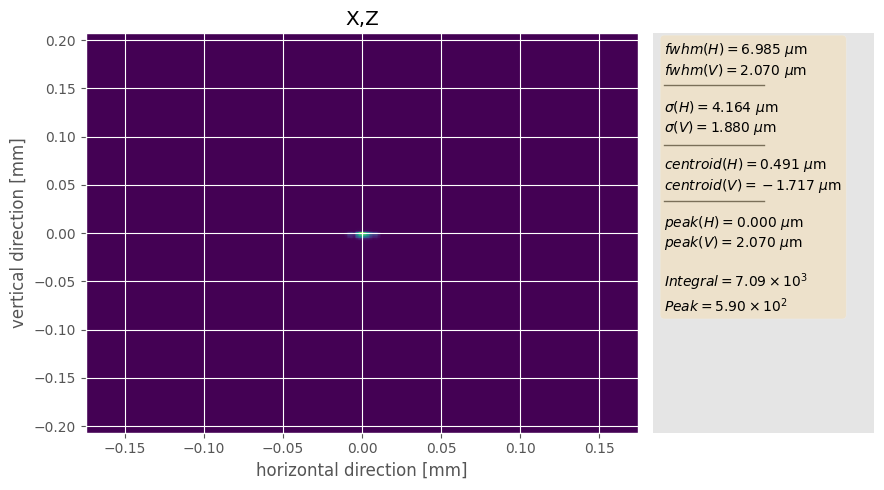

In [40]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp,focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

In [41]:
attribs_focus = print_beam_attributes(opt_params.params['loss_parameters'], hist, dw, "Focused beam", calc_params=cp)

Focused beam system fwhm: 5.484e-03
Focused beam system log_weighted_sum_intensity: -1.709e+00
Focused beam system peak_distance: 2.126e-03


In [42]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)



Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [31]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-176.40000000000003, -151.2, 0.17218733853924986, 0.0088, 411.4, 0.17120733853924985, 0.0149]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-8.44284761416155, 9.832900989223152, 0.00028229753685225377, 0.0044052370866311565, -7.64692471499173, -0.0006839261743900125, 0.014907739540629468]


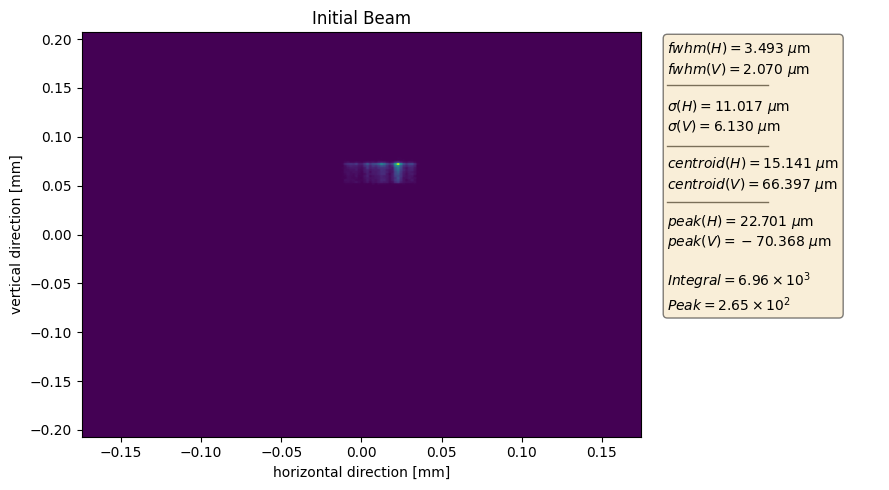

Perturbed beam system peak_distance: 7.675e-02
Perturbed beam system fwhm: 1.275e-02
Perturbed beam system log_weighted_sum_intensity: 3.511e+00


In [32]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert, ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam", calc_params=cp)

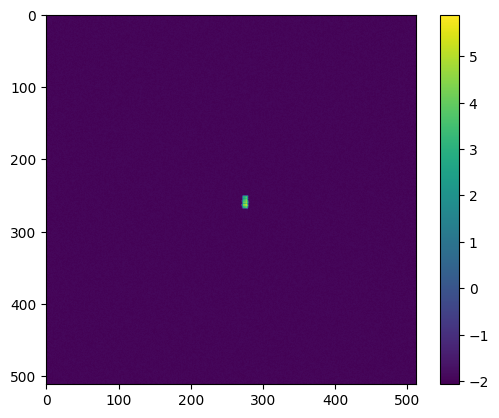

In [33]:
plt.imshow(np.log(hist_pert.data_2D))
plt.colorbar()

In [34]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### WITH MOO THRESHOLDS

In [66]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

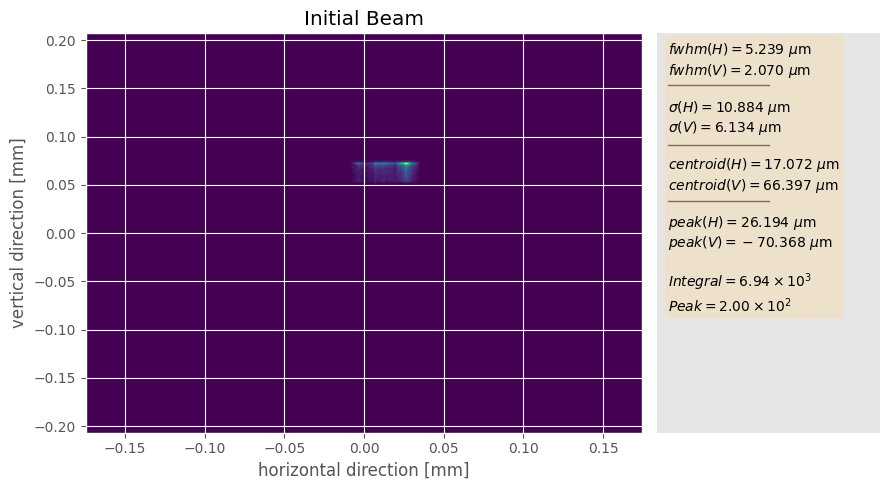

In [67]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [68]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam", calc_params=cp)

Perturbed beam system peak_distance: 7.763e-02
Perturbed beam system fwhm: 8.505e-03
Perturbed beam system log_weighted_sum_intensity: 3.521e+00


In [69]:
opt_params = OptimizationParameters()

In [70]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    )

In [71]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [72]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-01-22 12:13:14,238] A new study created in memory with name: no-name-bd0ad12d-1d90-43e7-ab1b-de0bb8783f27


In [78]:
opt_trial.trials(50)#, trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:18:12,840] Trial 50 finished with values: [0.008504608700029895, 1.1710646677306955, 0.015192422704809179] and parameters: {'hb_1': -10.5, 'hb_2': -12.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.007099999999999999, 'vb_bender': -2.0, 'vb_pitch': 0.00076, 'vb_trans': 0.00030000000000000165}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:18:17,378] Trial 51 finished with values: [0.010968749999999972, 4.21335529624729, 0.10702828812336562] and parameters: {'hb_1': -4.5, 'hb_2': -1.5, 'hb_pitch': 0.0005, 'hb_trans': 0.0007000000000000027, 'vb_bender': 4.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': 0.0057}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:18:22,053] Trial 52 finished with values: [0.0111866379730741, 0.21852820148700478, 0.011457334902641609] and parameters: {'hb_1': 2.5, 'hb_2': -9.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.0014999999999999996, 'vb_bender': -4.0, 'vb_pitch': 0.0008200000000000002, 'vb_trans': -9.99999999999994e-05}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:18:26,840] Trial 53 finished with values: [0.016479747943617104, 2.089124669805795, 0.014774551389954727] and parameters: {'hb_1': -10.5, 'hb_2': -9.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.009999999999999998, 'vb_bender': -6.0, 'vb_pitch': 0.0009400000000000001, 'vb_trans': -0.013999999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:18:31,817] Trial 54 finished with values: [0.02742187499999993, 2.1255197010565268, 0.03979491051571925] and parameters: {'hb_1': -0.5, 'hb_2': -5.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.012499999999999999, 'vb_bender': 4.0, 'vb_pitch': 0.0009600000000000003, 'vb_trans': 0.005200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:18:36,784] Trial 55 finished with values: [0.00705475671339243, -0.06317592054447295, 0.005064140901603024] and parameters: {'hb_1': 2.5, 'hb_2': -11.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.012299999999999998, 'vb_bender': 2.0, 'vb_pitch': 0.00076, 'vb_trans': -0.004199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:18:42,410] Trial 56 finished with values: [0.022176934103928733, 4.288175672473018, 0.10832859496880337] and parameters: {'hb_1': 5.5, 'hb_2': 3.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': 0.0036000000000000025, 'vb_bender': 7.0, 'vb_pitch': 0.0008000000000000001, 'vb_trans': -0.000899999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:18:47,737] Trial 57 finished with values: [0.006375019148255531, 1.1823005695826272, 0.017131354051153555] and parameters: {'hb_1': 3.5, 'hb_2': -12.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': -0.0132, 'vb_bender': 7.0, 'vb_pitch': 0.00084, 'vb_trans': 0.006200000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:18:53,786] Trial 58 finished with values: [0.023401727909293728, 4.798028095963805, 0.14899728457645542] and parameters: {'hb_1': 0.5, 'hb_2': 6.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.0059000000000000025, 'vb_bender': -8.0, 'vb_pitch': -0.00043999999999999996, 'vb_trans': 0.010600000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:18:59,615] Trial 59 finished with values: [0.022176934103928733, 3.178174421815507, 0.06263584662824404] and parameters: {'hb_1': 5.5, 'hb_2': 0.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': 0.0026000000000000016, 'vb_bender': 8.0, 'vb_pitch': 0.0005, 'vb_trans': 0.0010000000000000009}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:19:06,966] Trial 60 finished with values: [0.011440103870267053, 0.2689268252918839, 0.009106849490444066] and parameters: {'hb_1': 0.5, 'hb_2': -12.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.0010999999999999985, 'vb_bender': 10.0, 'vb_pitch': 0.0008200000000000002, 'vb_trans': 0.004400000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:19:13,258] Trial 61 finished with values: [0.016453124999999957, 4.746666894832732, 0.12253111557003352] and parameters: {'hb_1': 3.5, 'hb_2': -1.5, 'hb_pitch': -0.0008, 'hb_trans': -0.0003999999999999993, 'vb_bender': 6.0, 'vb_pitch': -0.00068, 'vb_trans': -0.0127}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:19:19,064] Trial 62 finished with values: [0.004252304350014948, 0.8469068904085394, 0.013267907475348662] and parameters: {'hb_1': -9.5, 'hb_2': -11.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': -0.013999999999999999, 'vb_bender': 2.0, 'vb_pitch': 0.0007000000000000001, 'vb_trans': -0.0092}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:19:24,145] Trial 63 finished with values: [0.03145372752310364, 1.8303929364161287, 0.03980372242604613] and parameters: {'hb_1': 4.5, 'hb_2': 11.5, 'hb_pitch': 0.0, 'hb_trans': -0.0052, 'vb_bender': -4.0, 'vb_pitch': 0.0008600000000000001, 'vb_trans': 0.008100000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:19:29,142] Trial 64 finished with values: [0.011440103870267053, -0.041620859760866, 0.005064140901603024] and parameters: {'hb_1': -3.5, 'hb_2': -11.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.011099999999999999, 'vb_bender': 6.0, 'vb_pitch': 0.0007000000000000001, 'vb_trans': -0.006199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:19:33,992] Trial 65 finished with values: [0.004252304350014948, 5.2715386618745095, 0.18288307936598125] and parameters: {'hb_1': -7.5, 'hb_2': -10.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0103, 'vb_bender': 1.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.0005999999999999981}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:19:38,702] Trial 66 finished with values: [0.005484374999999986, 4.196068623847732, 0.09038299322592469] and parameters: {'hb_1': 11.5, 'hb_2': -9.5, 'hb_pitch': -0.0009, 'hb_trans': 0.009300000000000003, 'vb_bender': 7.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.0017999999999999995}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:19:43,760] Trial 67 finished with values: [0.020256563606412096, 0.784549075037306, 0.011457334902641609] and parameters: {'hb_1': 8.5, 'hb_2': -10.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.0109, 'vb_bender': -7.0, 'vb_pitch': 0.0008000000000000001, 'vb_trans': -0.005899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:19:49,937] Trial 68 finished with values: [0.010968749999999972, 3.5609759160789745, 0.0754276626354643] and parameters: {'hb_1': -8.5, 'hb_2': -4.5, 'hb_pitch': 0.0005, 'hb_trans': 1.734723475976807e-18, 'vb_bender': 5.0, 'vb_pitch': 0.00076, 'vb_trans': -0.0073999999999999995}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:19:55,460] Trial 69 finished with values: [0.005484374999999986, -0.3484803704872122, 0.010764786597660133] and parameters: {'hb_1': 8.5, 'hb_2': -10.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.0058, 'vb_bender': 7.0, 'vb_pitch': 0.00084, 'vb_trans': -0.004899999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:20:00,777] Trial 70 finished with values: [0.00705475671339243, 0.7119379747299877, 0.013267907475348662] and parameters: {'hb_1': 1.5, 'hb_2': -9.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.007199999999999999, 'vb_bender': 1.0, 'vb_pitch': 0.0009000000000000002, 'vb_trans': -0.0036999999999999984}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:20:05,902] Trial 71 finished with values: [0.014090858991875019, 3.930132749085089, 0.08963753720837171] and parameters: {'hb_1': 10.5, 'hb_2': -6.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': 0.0072000000000000015, 'vb_bender': 1.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': 0.00030000000000000165}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:20:12,013] Trial 72 finished with values: [0.005484374999999986, 0.982024839345942, 0.011457334902641609] and parameters: {'hb_1': -6.5, 'hb_2': -10.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.013399999999999999, 'vb_bender': 3.0, 'vb_pitch': 0.0008800000000000001, 'vb_trans': -0.0116}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:20:17,859] Trial 73 finished with values: [0.01946850076335243, 0.7359328718229503, 0.015192422704809179] and parameters: {'hb_1': 0.5, 'hb_2': -12.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.0146, 'vb_bender': 7.0, 'vb_pitch': 0.0006600000000000002, 'vb_trans': -0.0017999999999999995}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:20:23,466] Trial 74 finished with values: [0.004252304350014948, 1.9012224542319356, 0.024684127847719096] and parameters: {'hb_1': 8.5, 'hb_2': -11.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.007599999999999999, 'vb_bender': 6.0, 'vb_pitch': 0.0008200000000000002, 'vb_trans': -0.012499999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:20:28,549] Trial 75 finished with values: [0.013710937499999964, 4.267845050150732, 0.09358620660661804] and parameters: {'hb_1': -8.5, 'hb_2': -0.5, 'hb_pitch': -0.001, 'hb_trans': 0.002100000000000001, 'vb_bender': 10.0, 'vb_pitch': 0.0006600000000000002, 'vb_trans': 0.0030000000000000027}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:20:33,892] Trial 76 finished with values: [0.013710937499999964, 1.1805068570783084, 0.018890693254244955] and parameters: {'hb_1': -2.5, 'hb_2': -12.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': -0.0132, 'vb_bender': 6.0, 'vb_pitch': 0.0009400000000000001, 'vb_trans': -0.003599999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:20:39,046] Trial 77 finished with values: [0.032906249999999915, 3.50404705402859, 0.06591071742523207] and parameters: {'hb_1': -7.5, 'hb_2': -1.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.012600000000000004, 'vb_bender': 0.0, 'vb_pitch': 0.00010000000000000005, 'vb_trans': -0.0138}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:20:43,821] Trial 78 finished with values: [0.029759718902244554, 4.033712596328832, 0.0741250585649076] and parameters: {'hb_1': 4.5, 'hb_2': -11.5, 'hb_pitch': -0.001, 'hb_trans': 0.010000000000000002, 'vb_bender': -10.0, 'vb_pitch': 0.0009400000000000001, 'vb_trans': 0.005600000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:20:49,175] Trial 79 finished with values: [0.021937499999999943, 0.6546023863644541, 0.011457334902641609] and parameters: {'hb_1': 12.5, 'hb_2': -8.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.006599999999999998, 'vb_bender': 10.0, 'vb_pitch': 0.0009400000000000001, 'vb_trans': -0.003999999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:20:54,231] Trial 80 finished with values: [0.02736256607068585, 3.797711543326242, 0.09269080571705887] and parameters: {'hb_1': 7.5, 'hb_2': -11.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': 0.0069, 'vb_bender': -6.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': -0.0002999999999999982}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:21:00,136] Trial 81 finished with values: [0.00884527165023244, 4.189572083956568, 0.10073199203510448] and parameters: {'hb_1': 8.5, 'hb_2': 0.5, 'hb_pitch': -0.0007, 'hb_trans': 0.0097, 'vb_bender': -2.0, 'vb_pitch': -0.00017999999999999993, 'vb_trans': -0.0084}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:21:06,257] Trial 82 finished with values: [0.01467569339290304, 0.3003832864980965, 0.012095854977702155] and parameters: {'hb_1': -4.5, 'hb_2': -12.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.011, 'vb_bender': -2.0, 'vb_pitch': 0.0008000000000000001, 'vb_trans': -0.0007999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:21:12,099] Trial 83 finished with values: [0.01919531249999995, 5.019980492382596, 0.1483727063047523] and parameters: {'hb_1': 10.5, 'hb_2': -7.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.009200000000000003, 'vb_bender': 8.0, 'vb_pitch': -0.0006399999999999999, 'vb_trans': -0.0006999999999999992}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:21:17,738] Trial 84 finished with values: [0.011440103870267053, -0.5913249138323766, 0.008412079218732188] and parameters: {'hb_1': 7.5, 'hb_2': -12.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.008299999999999998, 'vb_bender': 7.0, 'vb_pitch': 0.0008600000000000001, 'vb_trans': 0.0074}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:21:22,819] Trial 85 finished with values: [0.01715053553509688, 5.097116127855253, 0.1647466550264594] and parameters: {'hb_1': -7.5, 'hb_2': 1.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': 0.0069, 'vb_bender': -7.0, 'vb_pitch': -0.00066, 'vb_trans': 0.003700000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:21:27,968] Trial 86 finished with values: [0.004252304350014948, 4.232147802833285, 0.09344336449836561] and parameters: {'hb_1': 0.5, 'hb_2': 11.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0136, 'vb_bender': -1.0, 'vb_pitch': -0.00015999999999999999, 'vb_trans': 0.0074}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:21:33,497] Trial 87 finished with values: [0.002742187499999993, 0.47240854196961307, 0.011457334902641609] and parameters: {'hb_1': -0.5, 'hb_2': -12.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.003999999999999998, 'vb_bender': 6.0, 'vb_pitch': 0.0006200000000000001, 'vb_trans': -0.007199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:21:38,523] Trial 88 finished with values: [0.005484374999999986, 0.1503463676799813, 0.01468912941842671] and parameters: {'hb_1': 10.5, 'hb_2': -11.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': 0.0020000000000000018, 'vb_bender': 4.0, 'vb_pitch': 0.0008600000000000001, 'vb_trans': 0.014400000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:21:43,853] Trial 89 finished with values: [0.06140702577833725, 3.1820919008141, 0.08277201997444195] and parameters: {'hb_1': -7.5, 'hb_2': 3.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': -0.011899999999999999, 'vb_bender': -10.0, 'vb_pitch': 0.0005200000000000001, 'vb_trans': -0.008}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:21:50,259] Trial 90 finished with values: [0.026535814950697324, 4.282609993034374, 0.1007987346297269] and parameters: {'hb_1': 2.5, 'hb_2': 4.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.0020000000000000018, 'vb_bender': -3.0, 'vb_pitch': -0.00035999999999999997, 'vb_trans': -0.0101}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:21:56,075] Trial 91 finished with values: [0.005484374999999986, 4.67159394114705, 0.12175315931165054] and parameters: {'hb_1': 9.5, 'hb_2': -11.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': -0.004799999999999999, 'vb_bender': 7.0, 'vb_pitch': -1.9999999999999836e-05, 'vb_trans': 0.003500000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:22:01,762] Trial 92 finished with values: [0.006375019148255531, 0.6433272481805866, 0.005064140901603024] and parameters: {'hb_1': -12.5, 'hb_2': -10.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.0149, 'vb_bender': 5.0, 'vb_pitch': 0.0007400000000000002, 'vb_trans': -0.005899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:22:08,034] Trial 93 finished with values: [0.006375019148255531, -1.2325552878475583, 0.002126152175007474] and parameters: {'hb_1': 8.5, 'hb_2': -11.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': 0.0016000000000000007, 'vb_bender': 8.0, 'vb_pitch': 0.0007800000000000001, 'vb_trans': -0.0060999999999999995}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:22:14,106] Trial 94 finished with values: [0.004252304350014948, -0.2154110971800222, 0.010764786597660133] and parameters: {'hb_1': 9.5, 'hb_2': -10.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.002400000000000003, 'vb_bender': 8.0, 'vb_pitch': 0.0007400000000000002, 'vb_trans': -0.004599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:22:21,158] Trial 95 finished with values: [0.008226562499999979, 0.8841170872260093, 0.017927507441674317] and parameters: {'hb_1': -3.5, 'hb_2': -10.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.008799999999999999, 'vb_bender': 4.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': -0.0093}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:22:28,941] Trial 96 finished with values: [0.008504608700029895, 0.5809812451002813, 0.0070454294959375096] and parameters: {'hb_1': 4.5, 'hb_2': -11.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.005899999999999999, 'vb_bender': -3.0, 'vb_pitch': 0.00098, 'vb_trans': 0.0039000000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:22:36,761] Trial 97 finished with values: [0.029549102779909395, 3.461059335120413, 0.07692782826993817] and parameters: {'hb_1': 6.5, 'hb_2': -5.5, 'hb_pitch': -0.0005, 'hb_trans': 0.012100000000000003, 'vb_bender': -3.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': -0.0005999999999999981}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:22:43,844] Trial 98 finished with values: [0.002742187499999993, -1.3219578434944992, 0.002126152175007474] and parameters: {'hb_1': 5.5, 'hb_2': -11.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.0036999999999999984, 'vb_bender': 7.0, 'vb_pitch': 0.0008000000000000001, 'vb_trans': -0.004599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:22:48,894] Trial 99 finished with values: [0.008226562499999979, 4.139448874014384, 0.0959631945468762] and parameters: {'hb_1': 4.5, 'hb_2': -1.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': 0.005600000000000001, 'vb_bender': 9.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': 0.009000000000000001}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35131/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3DSubplot:title={'center':'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

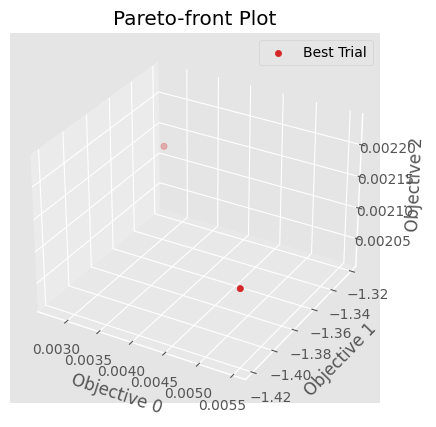

In [79]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [80]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

nan 0.24184037808321274
nan 0.26661280450377495


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35131/2890865355.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs['ws'])


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.005484374999999986, -1.419477365151204, 0.002126152175007474]


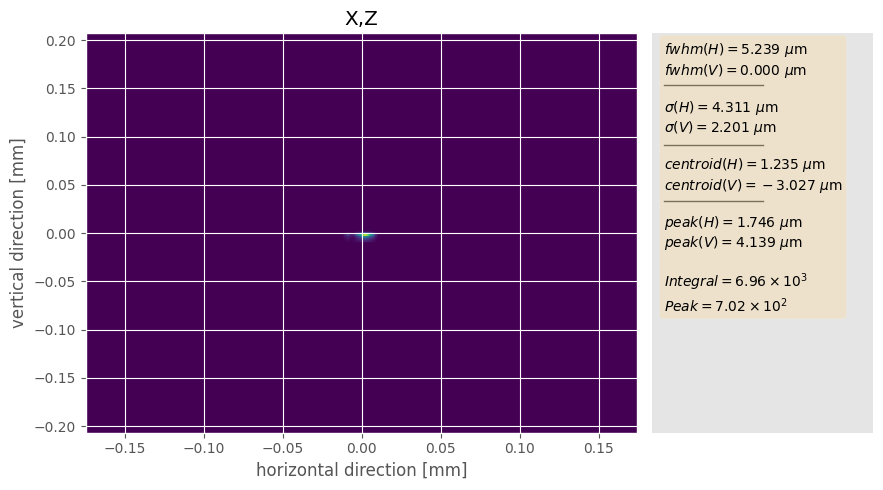

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.002742187499999993, -1.3219578434944992, 0.002126152175007474]


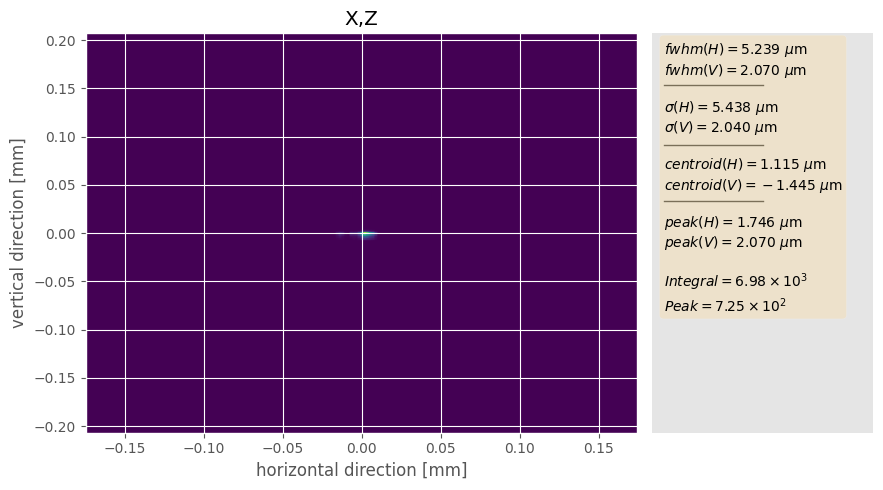

In [81]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    
    opt_common.plot_distribution(
        photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    #plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    #print(vals)
    #plt.figure(figsize=[5, 5])
    #plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    #plt.axis("off")
    #plt.show()

[0.002742187499999993, -1.3219578434944992, 0.002126152175007474]


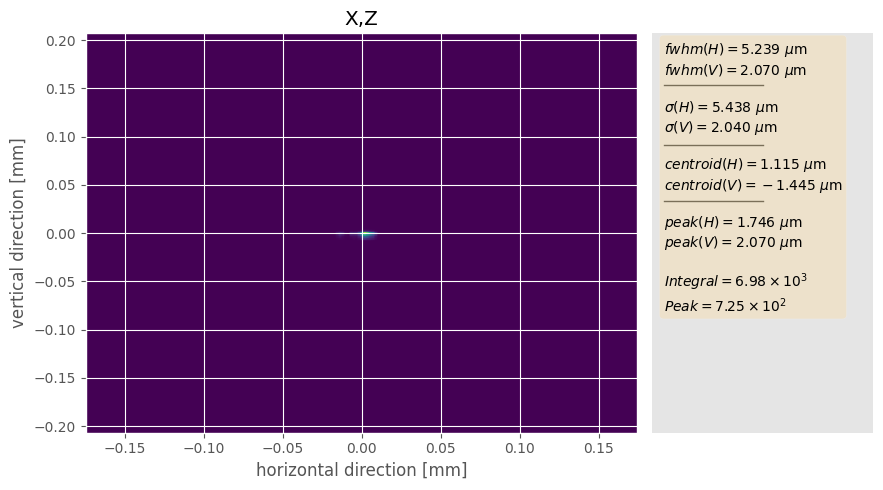

In [82]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

In [85]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.TOPSIS)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

[0.5 0.5 nan]
2


/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/optuna_botorch.py:339: RuntimeWarning: invalid value encountered in true_divide
  closeness = s_minus / (s_plus + s_minus)


IndexError: list index out of range

In [ ]:
opt_trial.trials(50)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35131/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3DSubplot:title={'center':'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

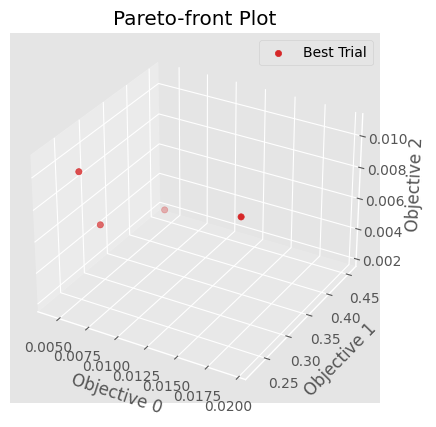

In [61]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [62]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

-9.981867451434915 1.246816117983465
-11.103674825592698 1.248786231659959
-12.404106487397252 1.5740887467647389
-11.452516771582054 1.298538022835249


[0.01946850076335243, 0.2205931963086094, 0.010764786597660133]


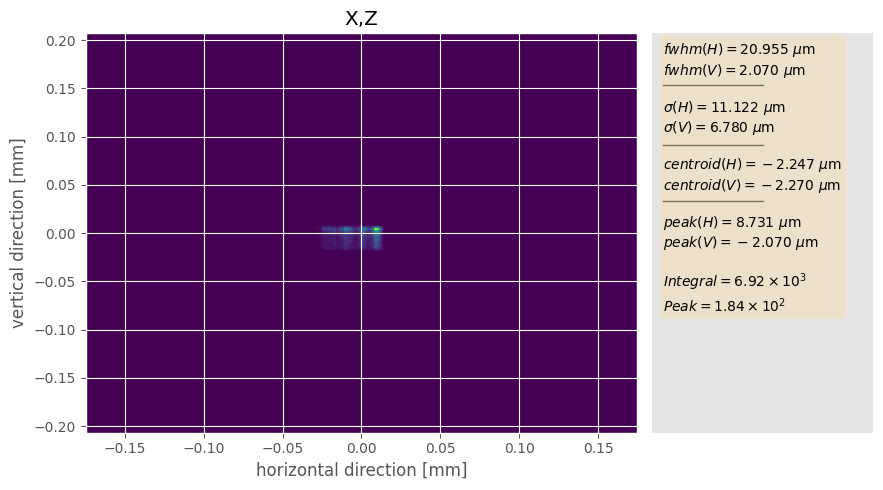

[0.006375019148255531, 0.2221720649020278, 0.010630760875037412]


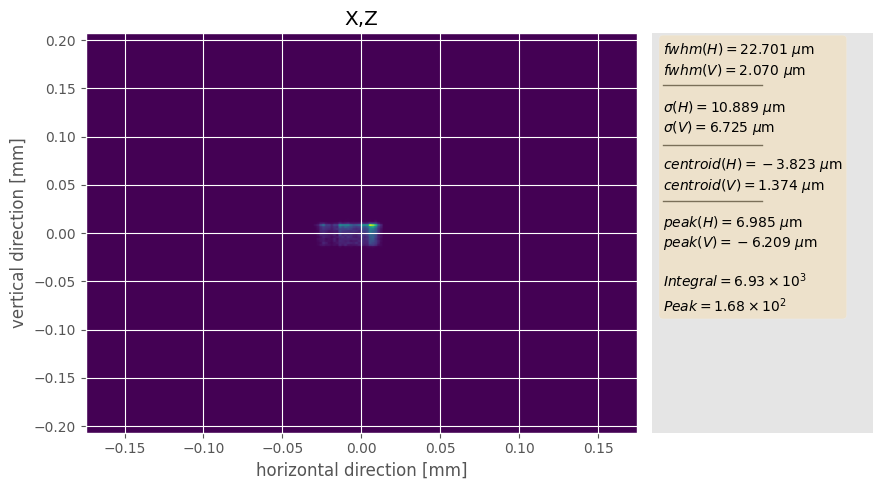

[0.004252304350014948, 0.4536765313566668, 0.002126152175007474]


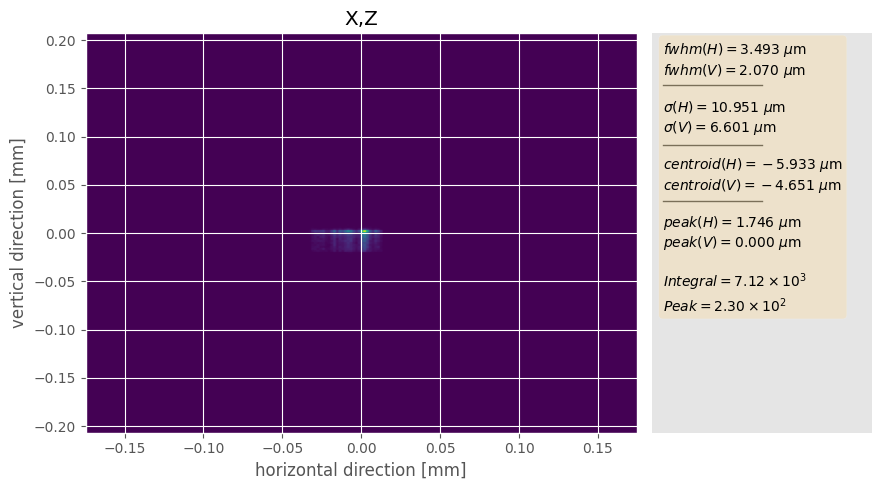

[0.006375019148255531, 0.26123903381382374, 0.006378456525022422]


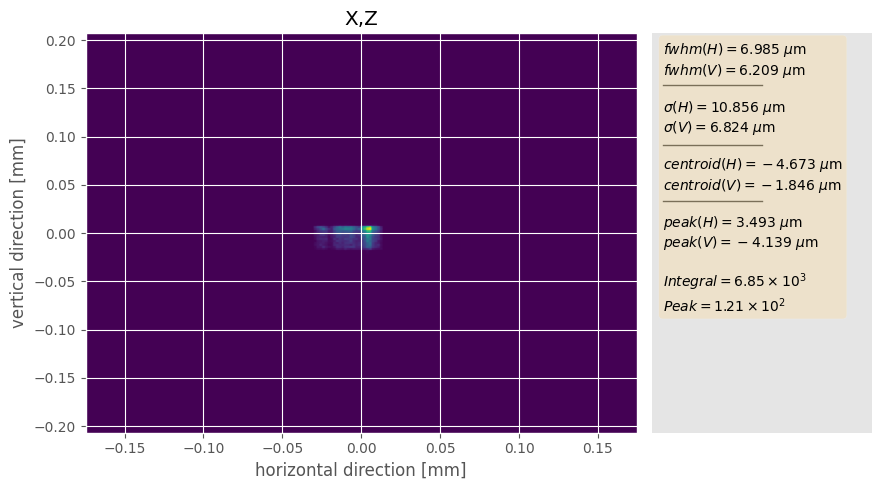

In [63]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    
    opt_common.plot_distribution(
        photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    #plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    #print(vals)
    #plt.figure(figsize=[5, 5])
    #plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    #plt.axis("off")
    #plt.show()

[0.004252304350014948, 0.4536765313566668, 0.002126152175007474]


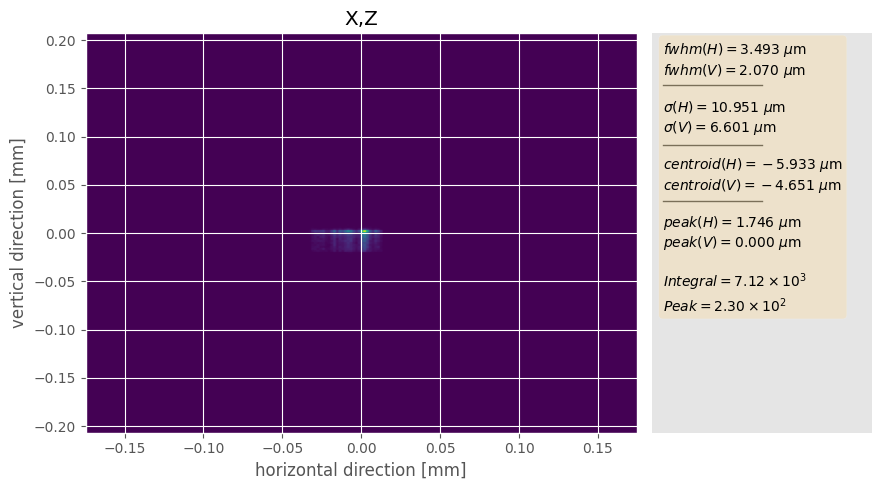

In [64]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

[0.004252304350014948, 0.4536765313566668, 0.002126152175007474]


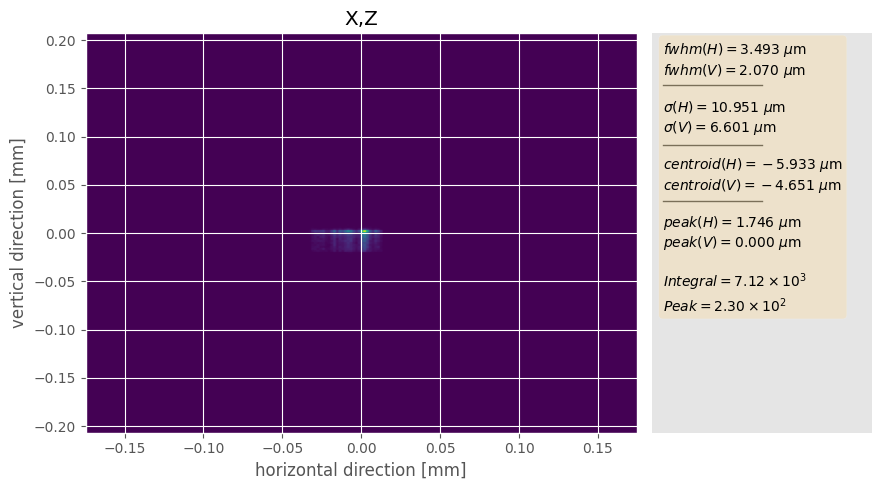

In [65]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.TOPSIS)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

### Different initial structure

In [15]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-159.0, -163.1, 0.17158733853924987, -0.0124, 412.20000000000005, 0.17158733853924987, -0.014599999999999998]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [8.975921989763336, -2.0994855103788836, -0.0003379747835474021, -0.006235183870419972, -6.813891687036291, -0.00029709069648093257, -0.01455684214734258]


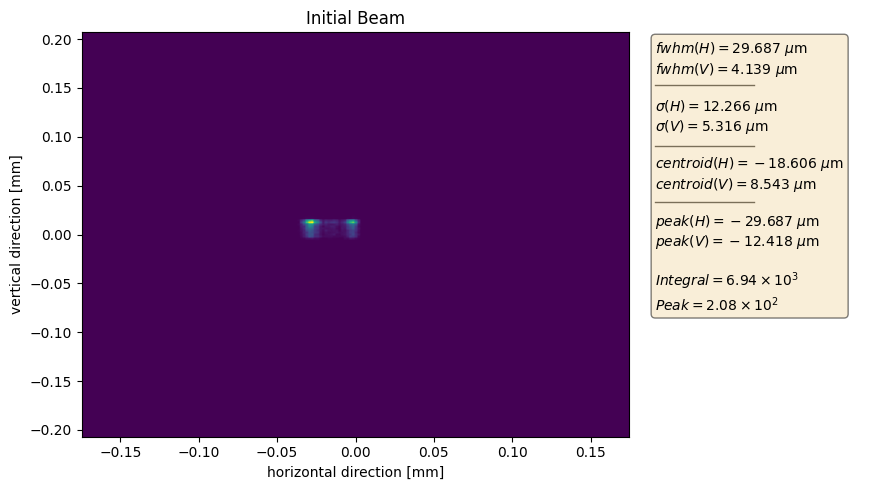

Perturbed beam system fwhm: 3.086e-02
Perturbed beam system log_weighted_sum_intensity: 1.429e+00
Perturbed beam system peak_distance: 3.229e-02


In [16]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert, ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam", calc_params=cp)

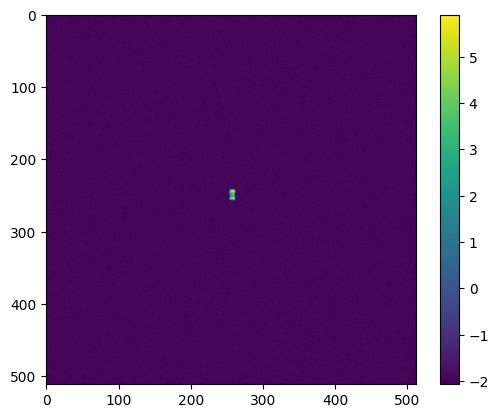

In [17]:
plt.imshow(np.log(hist_pert.data_2D))
plt.colorbar()

In [18]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

In [19]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

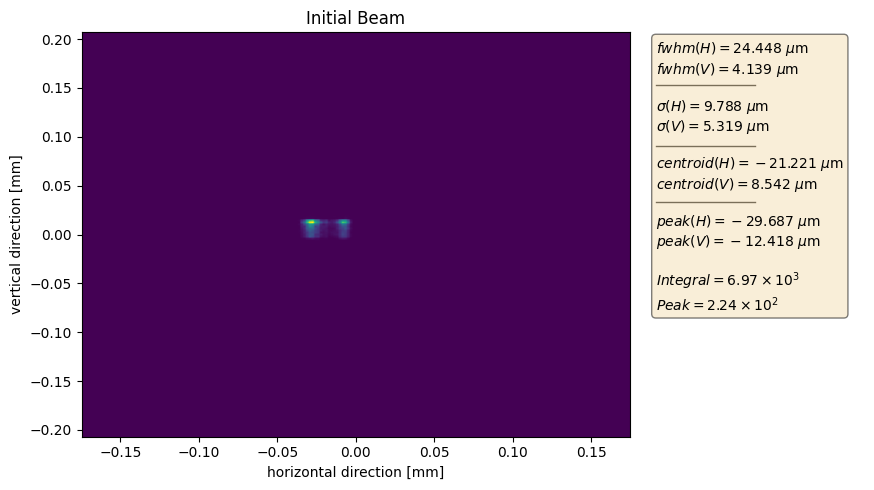

In [20]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [21]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam", calc_params=cp)

Perturbed beam system fwhm: 2.552e-02
Perturbed beam system log_weighted_sum_intensity: 1.513e+00
Perturbed beam system peak_distance: 3.229e-02


In [22]:
opt_params = OptimizationParameters()

In [23]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    )

In [24]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [25]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-01-22 12:44:15,847] A new study created in memory with name: no-name-a3f98dfe-b1bd-4aaf-a7cb-d79bbf1f7a2b
CA client library is unable to contact CA repeater after 50 tries.
Silence this message by starting a CA repeater daemon
or by calling ca_pend_event() and or ca_poll() more often.


In [32]:
opt_trial.trials(50)#, trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:48:40,469] Trial 50 finished with values: [0.011440103870267053, 1.0785849255895132, 0.023365169967336882] and parameters: {'hb_1': -1.5, 'hb_2': -2.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.0045000000000000005, 'vb_bender': 1.0, 'vb_pitch': 7.999999999999999e-05, 'vb_trans': -0.005099999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:48:46,635] Trial 51 finished with values: [0.032906249999999915, 0.9295011286682221, 0.002126152175007474] and parameters: {'hb_1': -12.5, 'hb_2': -5.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.008400000000000001, 'vb_bender': 5.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': 0.0019000000000000024}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:48:52,794] Trial 52 finished with values: [0.022880207740534106, 1.1059425136616103, 0.005064140901603024] and parameters: {'hb_1': -9.5, 'hb_2': -9.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': 0.0057, 'vb_bender': -2.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': -0.0087}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:48:59,154] Trial 53 finished with values: [0.014090858991875019, 0.35764077572486025, 0.010764786597660133] and parameters: {'hb_1': -8.5, 'hb_2': -4.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': -0.0026999999999999993, 'vb_bender': 7.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': -0.0003999999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:49:05,791] Trial 54 finished with values: [0.0202659818901689, 0.48937650253597287, 0.006378456525022422] and parameters: {'hb_1': -2.5, 'hb_2': -1.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': -0.0010999999999999985, 'vb_bender': 1.0, 'vb_pitch': 0.00014000000000000015, 'vb_trans': 0.005600000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:49:12,808] Trial 55 finished with values: [0.005484374999999986, -1.627123989559891, 0.002126152175007474] and parameters: {'hb_1': -9.5, 'hb_2': 1.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': 0.002100000000000001, 'vb_bender': 7.0, 'vb_pitch': 0.00010000000000000005, 'vb_trans': -0.001899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:49:18,206] Trial 56 finished with values: [0.005484374999999986, 3.9489801608890156, 0.07621250609050148] and parameters: {'hb_1': 5.5, 'hb_2': 3.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': 0.0036000000000000025, 'vb_bender': 7.0, 'vb_pitch': 0.0008000000000000001, 'vb_trans': -0.000899999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:49:23,737] Trial 57 finished with values: [0.016453124999999957, -0.31486656879061453, 0.008239873971808606] and parameters: {'hb_1': -3.5, 'hb_2': 2.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': 0.0036000000000000025, 'vb_bender': 8.0, 'vb_pitch': 0.0, 'vb_trans': -0.0010999999999999985}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:49:29,158] Trial 58 finished with values: [0.00884527165023244, -0.0242880667273, 0.006378456525022422] and parameters: {'hb_1': -12.5, 'hb_2': -1.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': -0.004499999999999999, 'vb_bender': 7.0, 'vb_pitch': 4.0000000000000105e-05, 'vb_trans': -0.012299999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:49:34,694] Trial 59 finished with values: [0.006375019148255531, -0.9942917441081831, 0.002126152175007474] and parameters: {'hb_1': -12.5, 'hb_2': 1.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': -0.001199999999999998, 'vb_bender': 8.0, 'vb_pitch': 0.00010000000000000005, 'vb_trans': -0.003599999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:49:40,168] Trial 60 finished with values: [0.005484374999999986, 0.6600300765530935, 0.014774551389954727] and parameters: {'hb_1': -6.5, 'hb_2': 1.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.0091, 'vb_bender': 7.0, 'vb_pitch': 6.000000000000016e-05, 'vb_trans': 0.005000000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:49:47,414] Trial 61 finished with values: [0.014090858991875019, 1.1974632249558146, 0.023056309311072533] and parameters: {'hb_1': -10.5, 'hb_2': -1.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.0063999999999999994, 'vb_bender': 3.0, 'vb_pitch': 0.0002000000000000001, 'vb_trans': -0.010599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:49:53,172] Trial 62 finished with values: [0.04673033993467354, 1.604121800524504, 0.023056309311072533] and parameters: {'hb_1': -11.5, 'hb_2': 5.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.0141, 'vb_bender': -1.0, 'vb_pitch': 0.00030000000000000014, 'vb_trans': -0.004299999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:49:58,965] Trial 63 finished with values: [0.06708416472052085, 3.3641289288399046, 0.045577268114427534] and parameters: {'hb_1': 4.5, 'hb_2': 11.5, 'hb_pitch': 0.0, 'hb_trans': -0.0052, 'vb_bender': -4.0, 'vb_pitch': 0.0008600000000000001, 'vb_trans': 0.008100000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:50:05,397] Trial 64 finished with values: [0.002742187499999993, -0.7541051293988226, 0.008239873971808606] and parameters: {'hb_1': -5.5, 'hb_2': 2.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': 0.004300000000000002, 'vb_bender': 2.0, 'vb_pitch': -5.999999999999994e-05, 'vb_trans': -0.007699999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:50:11,175] Trial 65 finished with values: [0.005484374999999986, 0.2929240057408347, 0.011457334902641609] and parameters: {'hb_1': -9.5, 'hb_2': 2.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': 0.010500000000000002, 'vb_bender': 9.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.010499999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:50:16,522] Trial 66 finished with values: [0.030164062499999922, 4.472465776715315, 0.10568671292869726] and parameters: {'hb_1': 11.5, 'hb_2': -9.5, 'hb_pitch': -0.0009, 'hb_trans': 0.009300000000000003, 'vb_bender': 7.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.0017999999999999995}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:50:23,029] Trial 67 finished with values: [0.028181717983750038, 1.8975872969841445, 0.03985732937254976] and parameters: {'hb_1': 6.5, 'hb_2': 6.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': 0.014100000000000001, 'vb_bender': -5.0, 'vb_pitch': -0.00019999999999999998, 'vb_trans': -0.0101}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:50:29,018] Trial 68 finished with values: [0.008226562499999979, 2.824035112318879, 0.054570000027067085] and parameters: {'hb_1': 8.5, 'hb_2': 5.5, 'hb_pitch': 0.0, 'hb_trans': 0.005200000000000003, 'vb_bender': 5.0, 'vb_pitch': 0.0007200000000000002, 'vb_trans': 0.011500000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:50:34,847] Trial 69 finished with values: [0.008504608700029895, 2.7970950642721624, 0.04064813062209984] and parameters: {'hb_1': -4.5, 'hb_2': 0.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': 0.0039000000000000007, 'vb_bender': -2.0, 'vb_pitch': 0.0006000000000000001, 'vb_trans': -0.009399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:50:40,591] Trial 70 finished with values: [0.057677575345656554, 4.005160253320542, 0.11444278863575262] and parameters: {'hb_1': -1.5, 'hb_2': 5.5, 'hb_pitch': 0.0009, 'hb_trans': -0.0124, 'vb_bender': 5.0, 'vb_pitch': 0.0005200000000000001, 'vb_trans': 0.0034000000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:50:46,137] Trial 71 finished with values: [0.022176934103928733, 3.0841929756763227, 0.05034143326281147] and parameters: {'hb_1': 10.5, 'hb_2': -6.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': 0.0072000000000000015, 'vb_bender': 1.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': 0.00030000000000000165}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:50:51,696] Trial 72 finished with values: [0.004252304350014948, 3.6486914235240735, 0.07466413658260554] and parameters: {'hb_1': 0.5, 'hb_2': -10.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': 0.010900000000000003, 'vb_bender': 8.0, 'vb_pitch': -0.00066, 'vb_trans': 0.010500000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:50:57,404] Trial 73 finished with values: [0.01919531249999995, 1.467365759637927, 0.029202751145028755] and parameters: {'hb_1': -10.5, 'hb_2': -9.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': -0.012199999999999999, 'vb_bender': 6.0, 'vb_pitch': 0.0003200000000000002, 'vb_trans': 0.011700000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:51:03,108] Trial 74 finished with values: [0.03852794554463834, 3.789531246887616, 0.06831074799492376] and parameters: {'hb_1': -11.5, 'hb_2': -11.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.0131, 'vb_bender': 3.0, 'vb_pitch': 0.0008200000000000002, 'vb_trans': -0.013399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:51:08,923] Trial 75 finished with values: [0.005484374999999986, 4.969686868574263, 0.1416872316819836] and parameters: {'hb_1': -8.5, 'hb_2': -0.5, 'hb_pitch': -0.001, 'hb_trans': 0.002100000000000001, 'vb_bender': 10.0, 'vb_pitch': 0.0006600000000000002, 'vb_trans': 0.0030000000000000027}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:51:14,826] Trial 76 finished with values: [0.006375019148255531, -0.14712605350930816, 0.006378456525022422] and parameters: {'hb_1': -6.5, 'hb_2': -0.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': 0.010900000000000003, 'vb_bender': 4.0, 'vb_pitch': 6.000000000000016e-05, 'vb_trans': -0.0116}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:51:19,978] Trial 77 finished with values: [0.021937499999999943, 0.8334590486510703, 0.017131354051153555] and parameters: {'hb_1': -7.5, 'hb_2': -1.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.012600000000000004, 'vb_bender': 0.0, 'vb_pitch': 0.00010000000000000005, 'vb_trans': -0.0138}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:51:25,480] Trial 78 finished with values: [0.02657213520100736, 4.957280566004465, 0.13225903202936548] and parameters: {'hb_1': 4.5, 'hb_2': -11.5, 'hb_pitch': -0.001, 'hb_trans': 0.010000000000000002, 'vb_bender': -10.0, 'vb_pitch': 0.0009400000000000001, 'vb_trans': 0.005600000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:51:31,442] Trial 79 finished with values: [0.01919531249999995, 1.8309365915015199, 0.026101414305270007] and parameters: {'hb_1': -6.5, 'hb_2': -3.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.0056999999999999985, 'vb_bender': 3.0, 'vb_pitch': 7.999999999999999e-05, 'vb_trans': -0.0013999999999999985}. 


KeyboardInterrupt: 

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_38118/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3DSubplot:title={'center':'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

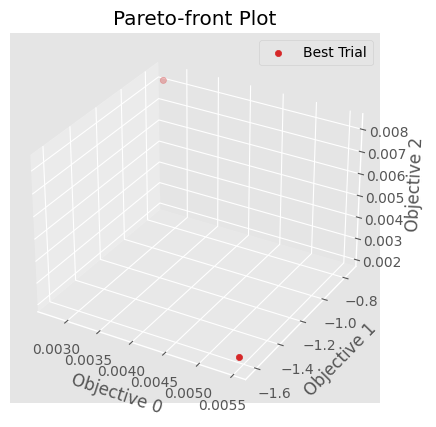

In [33]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [34]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

nan 0.19649388071447432
nan 0.4704314016587471


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_38118/2890865355.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs['ws'])


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.005484374999999986, -1.627123989559891, 0.002126152175007474]


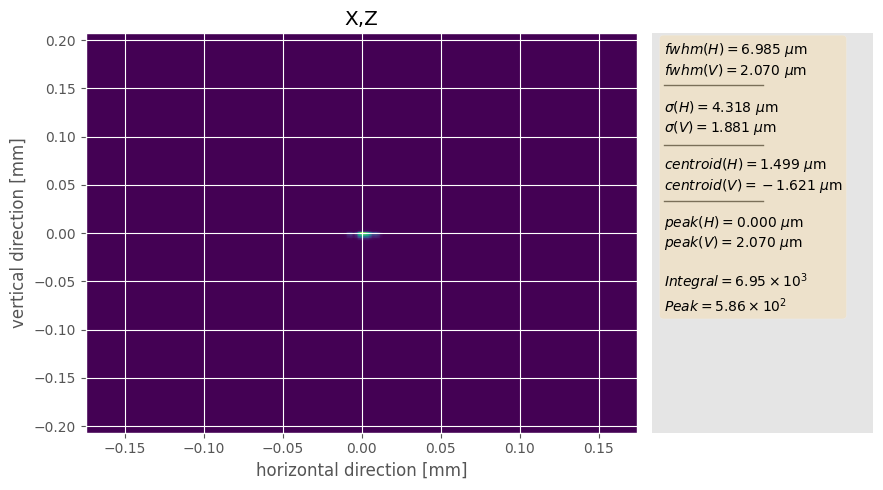

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.002742187499999993, -0.7541051293988226, 0.008239873971808606]


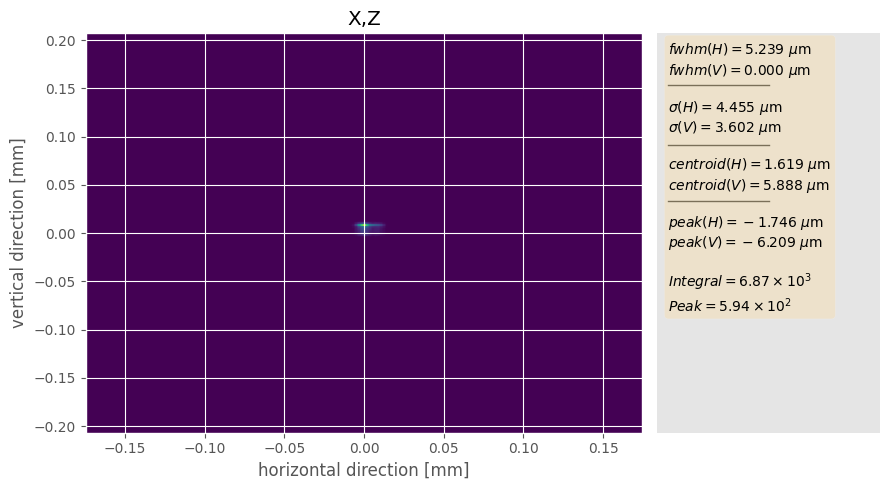

In [35]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    
    opt_common.plot_distribution(
        photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    #plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    #print(vals)
    #plt.figure(figsize=[5, 5])
    #plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    #plt.axis("off")
    #plt.show()

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.005484374999999986, -1.627123989559891, 0.002126152175007474]


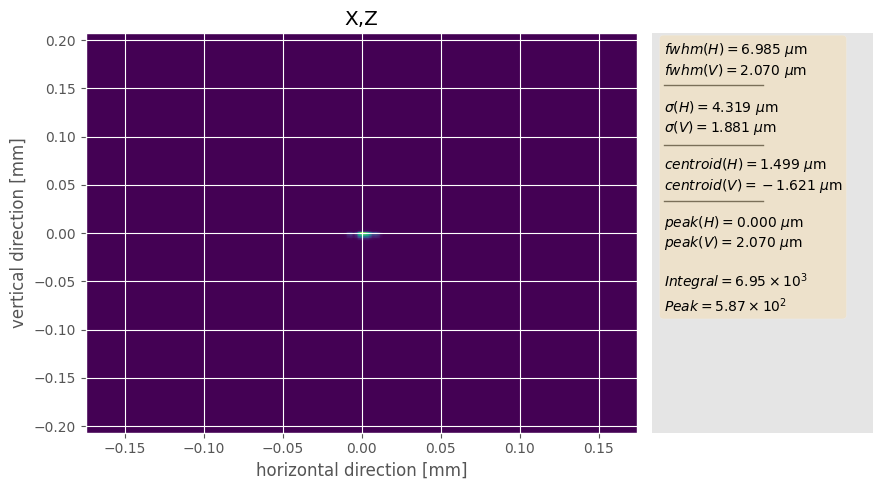

In [36]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

2
[0.5 0.5 0.5]
0
[0.005484374999999986, -1.627123989559891, 0.002126152175007474]


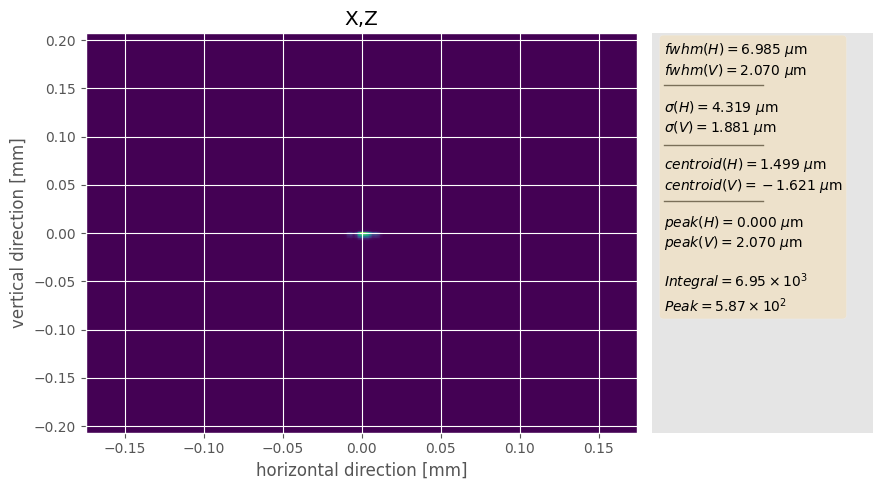

In [37]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.TOPSIS)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

### Different initial structure

In [43]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), list(initial_absolute_positions.values()), movement='absolute')

In [44]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-170.1, -164.1, 0.17098733853924986, 0.0164, 416.6000000000001, 0.17186733853924988, -0.0033]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-2.101940790476517, -3.1391964745545646, -0.0008692923643367672, 0.008172975206749065, -2.421310561048222, -1.552369926081541e-05, -0.0032790133668567107]


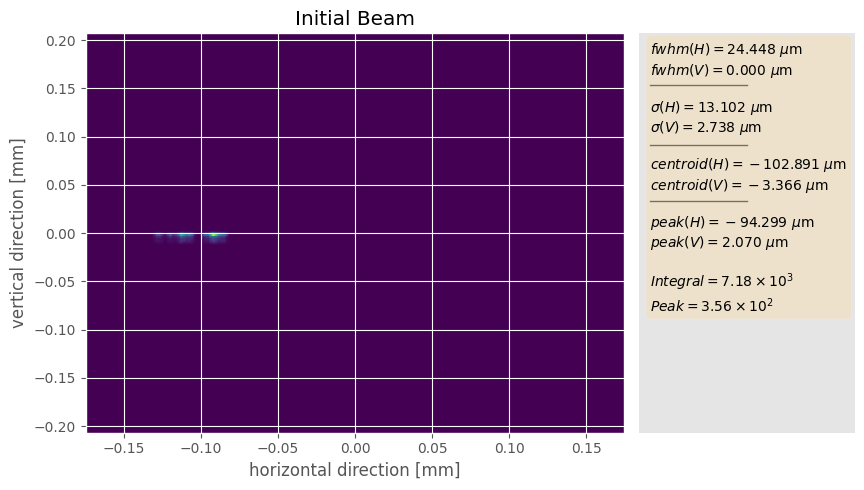

Perturbed beam system fwhm: 2.468e-02
Perturbed beam system log_weighted_sum_intensity: 4.349e+00
Perturbed beam system peak_distance: 9.188e-02


In [45]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert, ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam", calc_params=cp)

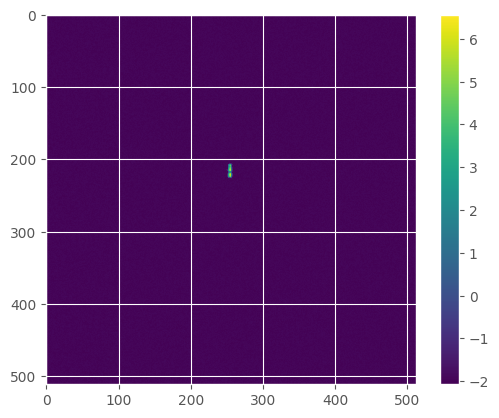

In [46]:
plt.imshow(np.log(hist_pert.data_2D))
plt.colorbar()

In [47]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

In [48]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

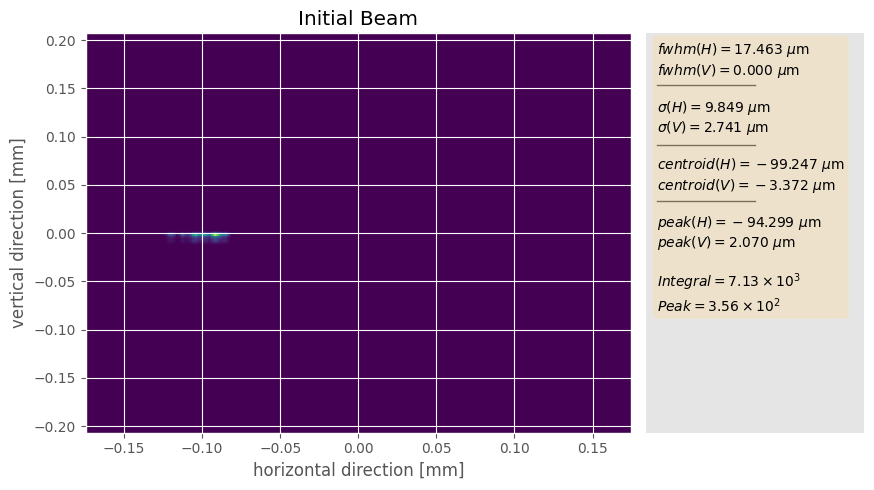

In [49]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [50]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam", calc_params=cp)

Perturbed beam system fwhm: 1.645e-02
Perturbed beam system log_weighted_sum_intensity: 4.264e+00
Perturbed beam system peak_distance: 9.188e-02


In [51]:
opt_params = OptimizationParameters()

In [52]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    )

In [53]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [54]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-01-22 13:19:57,974] A new study created in memory with name: no-name-5effc7a1-bfe1-4c96-880d-dfc1634732b0


In [60]:
opt_trial.trials(50)#, trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:52:39,697] Trial 50 finished with values: [0.016453124999999957, 0.36739504049032506, 0.011457334902641609] and parameters: {'hb_1': -2.5, 'hb_2': -2.5, 'hb_pitch': 0.0009, 'hb_trans': -0.004499999999999999, 'vb_bender': 4.0, 'vb_pitch': -0.00019999999999999998, 'vb_trans': -0.002599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:52:44,165] Trial 51 finished with values: [0.024679687499999936, 2.8899186931081573, 0.037055179381157065] and parameters: {'hb_1': -4.5, 'hb_2': -1.5, 'hb_pitch': 0.0005, 'hb_trans': 0.0007000000000000027, 'vb_bender': 4.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': 0.0057}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:52:47,814] Trial 52 finished with values: [0.01919531249999995, 4.373207269951055, 0.10479893039128423] and parameters: {'hb_1': 4.5, 'hb_2': 9.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.0023999999999999994, 'vb_bender': 7.0, 'vb_pitch': 0.00084, 'vb_trans': 0.0025000000000000022}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:52:51,232] Trial 53 finished with values: [0.01715053553509688, 4.827559830968377, 0.12313531698774673] and parameters: {'hb_1': 12.5, 'hb_2': -10.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.006299999999999998, 'vb_bender': -9.0, 'vb_pitch': 0.0009600000000000003, 'vb_trans': 0.006700000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:52:54,600] Trial 54 finished with values: [0.008226562499999979, 0.08060501449079864, 0.01257500021841604] and parameters: {'hb_1': 12.5, 'hb_2': -1.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0022000000000000006, 'vb_bender': 1.0, 'vb_pitch': -0.00028, 'vb_trans': -0.0113}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:52:57,929] Trial 55 finished with values: [0.014090858991875019, -0.07315588372808676, 0.00442263582511622] and parameters: {'hb_1': 11.5, 'hb_2': 0.5, 'hb_pitch': 0.0009, 'hb_trans': -0.0002999999999999982, 'vb_bender': 10.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.012199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:53:01,397] Trial 56 finished with values: [0.006375019148255531, -1.0757977863899029, 0.005064140901603024] and parameters: {'hb_1': 1.5, 'hb_2': 1.5, 'hb_pitch': 0.0009, 'hb_trans': -0.004399999999999999, 'vb_bender': 4.0, 'vb_pitch': -1.9999999999999836e-05, 'vb_trans': -0.002899999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:53:05,045] Trial 57 finished with values: [0.024679687499999936, 2.0972198472060626, 0.032332346504594475] and parameters: {'hb_1': 2.5, 'hb_2': -4.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': -0.0022999999999999982, 'vb_bender': 5.0, 'vb_pitch': 0.0002800000000000001, 'vb_trans': -0.0063999999999999994}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:53:08,726] Trial 58 finished with values: [0.01769054330046488, 3.315840127131728, 0.06417659154983305] and parameters: {'hb_1': 0.5, 'hb_2': 6.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.0059000000000000025, 'vb_bender': -8.0, 'vb_pitch': -0.00043999999999999996, 'vb_trans': 0.010600000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:53:12,571] Trial 59 finished with values: [0.01769054330046488, 3.78728408225274, 0.0738727569497738] and parameters: {'hb_1': 5.5, 'hb_2': 0.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': 0.0026000000000000016, 'vb_bender': 8.0, 'vb_pitch': 0.0005, 'vb_trans': 0.0010000000000000009}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:53:16,671] Trial 60 finished with values: [0.005484374999999986, 4.311516102183352, 0.10431809892022142] and parameters: {'hb_1': -9.5, 'hb_2': 4.5, 'hb_pitch': 0.0005, 'hb_trans': -0.003899999999999999, 'vb_bender': 8.0, 'vb_pitch': -0.00096, 'vb_trans': 0.014700000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:53:20,956] Trial 61 finished with values: [0.021937499999999943, 5.49170044577991, 0.1814766498184306] and parameters: {'hb_1': 3.5, 'hb_2': -1.5, 'hb_pitch': -0.0008, 'hb_trans': -0.0003999999999999993, 'vb_bender': 6.0, 'vb_pitch': -0.00068, 'vb_trans': -0.0127}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:53:24,596] Trial 62 finished with values: [0.011440103870267053, 3.6386764499524213, 0.06813975267173375] and parameters: {'hb_1': -1.5, 'hb_2': 7.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': -0.002899999999999998, 'vb_bender': 8.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.0112}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:53:28,246] Trial 63 finished with values: [0.028181717983750038, 4.633346089377378, 0.11441845044558223] and parameters: {'hb_1': 4.5, 'hb_2': 11.5, 'hb_pitch': 0.0, 'hb_trans': -0.0052, 'vb_bender': -4.0, 'vb_pitch': 0.0008600000000000001, 'vb_trans': 0.008100000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:53:31,751] Trial 64 finished with values: [0.021937499999999943, 5.048336522886473, 0.14678800578789977] and parameters: {'hb_1': -10.5, 'hb_2': 12.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.008100000000000003, 'vb_bender': 7.0, 'vb_pitch': -3.999999999999989e-05, 'vb_trans': 0.002700000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:53:35,351] Trial 65 finished with values: [0.002742187499999993, 3.3650566769900925, 0.060866046975620834] and parameters: {'hb_1': -7.5, 'hb_2': -10.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0103, 'vb_bender': 1.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.0005999999999999981}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:53:44,910] Trial 66 finished with values: [0.006375019148255531, -1.322827064796566, 0.005064140901603024] and parameters: {'hb_1': 3.5, 'hb_2': 3.5, 'hb_pitch': 0.0009, 'hb_trans': 0.00030000000000000165, 'vb_bender': 0.0, 'vb_pitch': -0.00019999999999999998, 'vb_trans': -0.011099999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:53:58,203] Trial 67 finished with values: [0.0111866379730741, 0.40309119469316784, 0.010630760875037412] and parameters: {'hb_1': 12.5, 'hb_2': -5.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0034000000000000002, 'vb_bender': 10.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': -0.0112}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:54:19,607] Trial 68 finished with values: [0.005484374999999986, -1.3346164509682876, 0.005064140901603024] and parameters: {'hb_1': 5.5, 'hb_2': 1.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0007000000000000027, 'vb_bender': 4.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': -0.011}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:54:38,445] Trial 69 finished with values: [0.005484374999999986, -1.6696169474525173, 0.002126152175007474] and parameters: {'hb_1': 1.5, 'hb_2': 1.5, 'hb_pitch': 0.0009, 'hb_trans': -0.003899999999999999, 'vb_bender': 2.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': -0.015}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:54:49,289] Trial 70 finished with values: [0.00884527165023244, -0.48459243145112096, 0.006378456525022422] and parameters: {'hb_1': -4.5, 'hb_2': -0.5, 'hb_pitch': 0.0009, 'hb_trans': -0.010499999999999999, 'vb_bender': 1.0, 'vb_pitch': -0.0002599999999999999, 'vb_trans': -0.015}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:55:03,040] Trial 71 finished with values: [0.006375019148255531, -0.9581116804259802, 0.006378456525022422] and parameters: {'hb_1': 2.5, 'hb_2': 0.5, 'hb_pitch': 0.0009, 'hb_trans': -0.004299999999999998, 'vb_bender': 7.0, 'vb_pitch': -0.0002599999999999999, 'vb_trans': -0.015}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:55:14,469] Trial 72 finished with values: [0.005484374999999986, -0.953643652659248, 0.005064140901603024] and parameters: {'hb_1': 3.5, 'hb_2': 3.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0008000000000000021, 'vb_bender': 6.0, 'vb_pitch': -7.999999999999999e-05, 'vb_trans': 0.0006000000000000016}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:55:26,427] Trial 73 finished with values: [0.005484374999999986, -0.9876198411864402, 0.005064140901603024] and parameters: {'hb_1': 3.5, 'hb_2': 1.5, 'hb_pitch': 0.0009, 'hb_trans': -0.0004999999999999987, 'vb_bender': 3.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': -0.0112}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:55:43,192] Trial 74 finished with values: [0.006375019148255531, -0.4438910468465746, 0.008239873971808606] and parameters: {'hb_1': 4.5, 'hb_2': 2.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0029, 'vb_bender': 2.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': -0.009899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:56:04,554] Trial 75 finished with values: [0.005484374999999986, -1.400201968024607, 0.002126152175007474] and parameters: {'hb_1': 1.5, 'hb_2': 3.5, 'hb_pitch': 0.0009, 'hb_trans': -0.0016999999999999984, 'vb_bender': 5.0, 'vb_pitch': -9.999999999999994e-05, 'vb_trans': -0.004199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:56:19,679] Trial 76 finished with values: [0.006375019148255531, -1.4973801627113263, 0.005064140901603024] and parameters: {'hb_1': 3.5, 'hb_2': 2.5, 'hb_pitch': 0.0009, 'hb_trans': -0.0006999999999999992, 'vb_bender': 3.0, 'vb_pitch': -0.00015999999999999999, 'vb_trans': -0.006999999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(
[I 2023-01-22 13:56:33,233] Trial 77 finished with values: [0.004252304350014948, -1.5120310022496135, 0.002126152175007474] and parameters: {'hb_1': 3.5, 'hb_2': 2.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0005000000000000004, 'vb_bender': 3.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': -0.015}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:56:43,457] Trial 78 finished with values: [0.006375019148255531, 0.772364773192771, 0.016782799789499182] and parameters: {'hb_1': 0.5, 'hb_2': 4.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': -0.0019999999999999983, 'vb_bender': 10.0, 'vb_pitch': 0.0, 'vb_trans': 0.009400000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:56:57,405] Trial 79 finished with values: [0.004252304350014948, -1.484311250373441, 0.002126152175007474] and parameters: {'hb_1': 3.5, 'hb_2': 2.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0006000000000000016, 'vb_bender': 3.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': -0.015}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:57:10,362] Trial 80 finished with values: [0.002742187499999993, -0.9995578017577639, 0.002126152175007474] and parameters: {'hb_1': 2.5, 'hb_2': 2.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0010000000000000009, 'vb_bender': 5.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': -0.0138}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:57:14,733] Trial 81 finished with values: [0.024679687499999936, 5.429867016991835, 0.16871497724129955] and parameters: {'hb_1': 8.5, 'hb_2': 0.5, 'hb_pitch': -0.0007, 'hb_trans': 0.0097, 'vb_bender': -2.0, 'vb_pitch': -0.00017999999999999993, 'vb_trans': -0.0084}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:57:19,804] Trial 82 finished with values: [0.04576041548106821, 4.644238195327333, 0.09187765270737275] and parameters: {'hb_1': -5.5, 'hb_2': -0.5, 'hb_pitch': 0.0, 'hb_trans': 0.014500000000000002, 'vb_bender': -8.0, 'vb_pitch': 6.000000000000016e-05, 'vb_trans': -0.0010999999999999985}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:57:24,088] Trial 83 finished with values: [0.024892759491419447, 3.1872638599567655, 0.06417659154983305] and parameters: {'hb_1': 10.5, 'hb_2': -7.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.009200000000000003, 'vb_bender': 8.0, 'vb_pitch': -0.0006399999999999999, 'vb_trans': -0.0006999999999999992}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:57:28,341] Trial 84 finished with values: [0.008226562499999979, 4.308605261384677, 0.10284486995470886] and parameters: {'hb_1': 0.5, 'hb_2': -7.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': -0.0136, 'vb_bender': 5.0, 'vb_pitch': 0.00010000000000000005, 'vb_trans': 0.0085}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:57:32,621] Trial 85 finished with values: [0.0276137959816397, 3.329079320037672, 0.060886210511848754] and parameters: {'hb_1': -7.5, 'hb_2': 1.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': 0.0069, 'vb_bender': -7.0, 'vb_pitch': -0.00066, 'vb_trans': 0.003700000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:57:36,974] Trial 86 finished with values: [0.04113281249999989, 5.225469141598444, 0.14779197760091206] and parameters: {'hb_1': 0.5, 'hb_2': 11.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0136, 'vb_bender': -1.0, 'vb_pitch': -0.00015999999999999999, 'vb_trans': 0.0074}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:57:41,742] Trial 87 finished with values: [0.024679687499999936, 4.424937807913904, 0.11432817364793713] and parameters: {'hb_1': -4.5, 'hb_2': -6.5, 'hb_pitch': 0.0, 'hb_trans': 0.00010000000000000113, 'vb_bender': 1.0, 'vb_pitch': 0.00038000000000000013, 'vb_trans': -0.0118}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:57:46,570] Trial 88 finished with values: [0.02552130433770289, 4.725512060435927, 0.12079245537698528] and parameters: {'hb_1': -1.5, 'hb_2': 6.5, 'hb_pitch': 0.0, 'hb_trans': 0.008200000000000002, 'vb_bender': -9.0, 'vb_pitch': -0.00088, 'vb_trans': -0.0139}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:57:51,709] Trial 89 finished with values: [0.018894173893793366, 3.8976358504672124, 0.07617798543199701] and parameters: {'hb_1': -7.5, 'hb_2': 3.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': -0.011899999999999999, 'vb_bender': -10.0, 'vb_pitch': 0.0005200000000000001, 'vb_trans': -0.008}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:57:56,703] Trial 90 finished with values: [0.006375019148255531, 5.305676224650149, 0.16413638296405955] and parameters: {'hb_1': 2.5, 'hb_2': 4.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.0020000000000000018, 'vb_bender': -3.0, 'vb_pitch': -0.00035999999999999997, 'vb_trans': -0.0101}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:58:01,558] Trial 91 finished with values: [0.005484374999999986, 0.9378427352492112, 0.015850340426185647] and parameters: {'hb_1': 9.5, 'hb_2': -11.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': -0.004799999999999999, 'vb_bender': 7.0, 'vb_pitch': -1.9999999999999836e-05, 'vb_trans': 0.003500000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:58:05,793] Trial 92 finished with values: [0.0111866379730741, 5.13928063739758, 0.14779197760091206] and parameters: {'hb_1': -12.5, 'hb_2': 6.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.004699999999999999, 'vb_bender': -10.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': -0.012499999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:58:09,890] Trial 93 finished with values: [0.022176934103928733, 4.939141317893454, 0.13315111985403574] and parameters: {'hb_1': 2.5, 'hb_2': 12.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.0037999999999999996, 'vb_bender': 1.0, 'vb_pitch': 0.00030000000000000014, 'vb_trans': -0.002599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:58:14,942] Trial 94 finished with values: [0.016771041180130213, 4.100976121222842, 0.09592707160659393] and parameters: {'hb_1': -2.5, 'hb_2': 6.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.0081, 'vb_bender': 5.0, 'vb_pitch': -0.00047999999999999996, 'vb_trans': -0.008199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:58:19,487] Trial 95 finished with values: [0.023125047508397025, 3.4576928345928684, 0.06340886546343778] and parameters: {'hb_1': 3.5, 'hb_2': -5.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.0115, 'vb_bender': -10.0, 'vb_pitch': 0.0003200000000000002, 'vb_trans': 0.003500000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:58:24,155] Trial 96 finished with values: [0.016453124999999957, -0.08183066986593525, 0.002126152175007474] and parameters: {'hb_1': 2.5, 'hb_2': 2.5, 'hb_pitch': 0.0009, 'hb_trans': 0.004900000000000002, 'vb_bender': 2.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.0109}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:58:28,850] Trial 97 finished with values: [0.05493996190445061, 5.1905725867580275, 0.17176378544062076] and parameters: {'hb_1': 6.5, 'hb_2': -5.5, 'hb_pitch': -0.0005, 'hb_trans': 0.012100000000000003, 'vb_bender': -3.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': -0.0005999999999999981}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:58:33,740] Trial 98 finished with values: [0.043874999999999886, 3.3277324572829112, 0.07355286743051546] and parameters: {'hb_1': 9.5, 'hb_2': -4.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.014400000000000003, 'vb_bender': 8.0, 'vb_pitch': -0.00011999999999999999, 'vb_trans': 0.0020000000000000018}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 13:58:39,174] Trial 99 finished with values: [0.03623618490116473, 4.538543445704006, 0.10736709121514365] and parameters: {'hb_1': 4.5, 'hb_2': -1.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': 0.005600000000000001, 'vb_bender': 9.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': 0.009000000000000001}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_38118/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3DSubplot:title={'center':'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

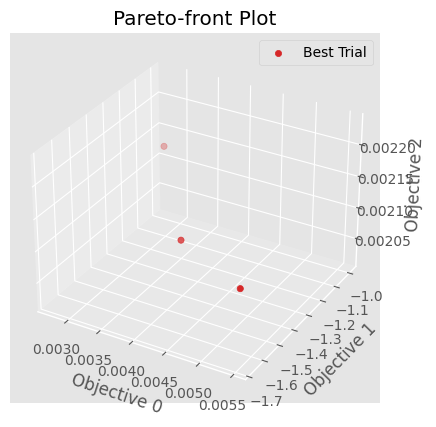

In [61]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [62]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

nan 0.1883191879692352
nan 0.22046176461241082
nan 0.3680421527864268


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_38118/2890865355.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs['ws'])


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.005484374999999986, -1.6696169474525173, 0.002126152175007474]


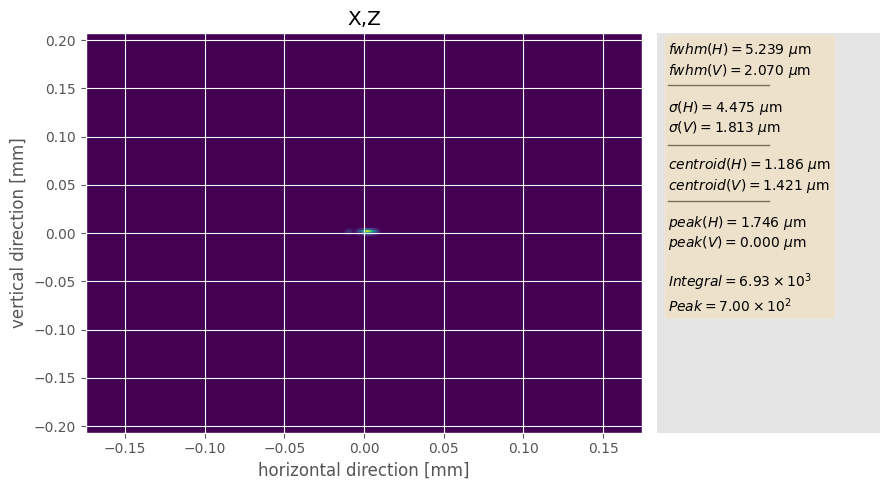

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.004252304350014948, -1.5120310022496135, 0.002126152175007474]


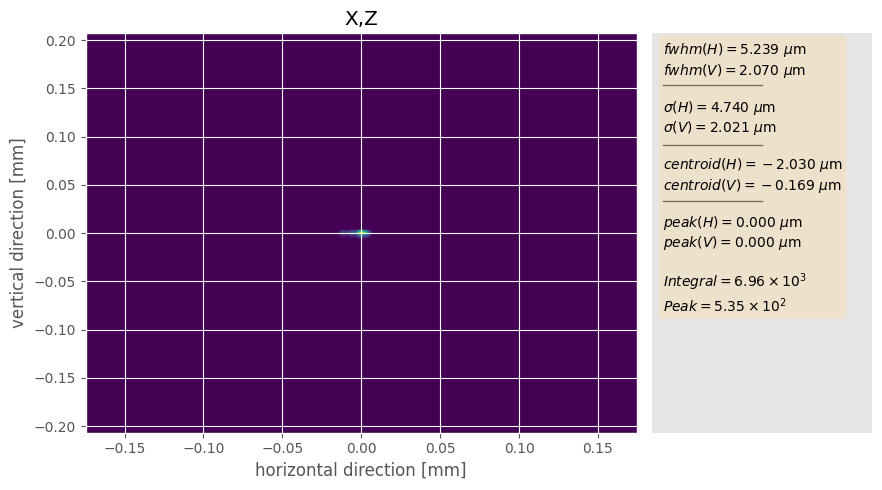

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.002742187499999993, -0.9995578017577639, 0.002126152175007474]


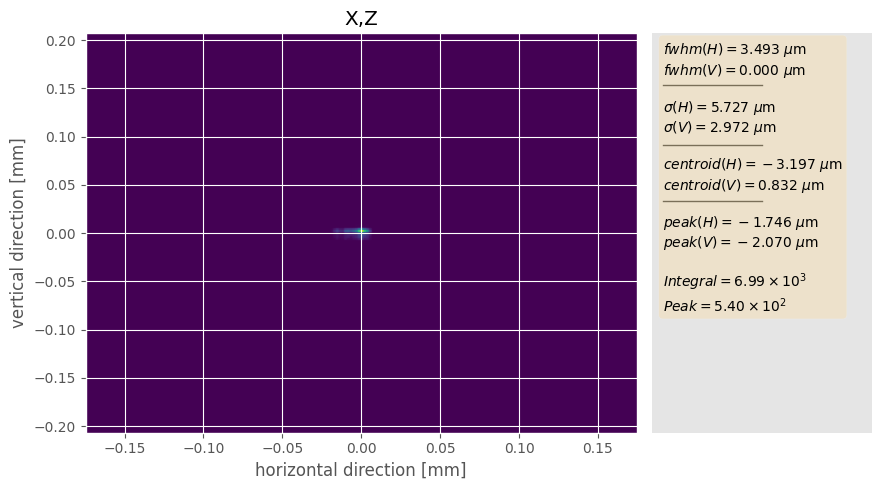

In [63]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    
    opt_common.plot_distribution(
        photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    #plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    #print(vals)
    #plt.figure(figsize=[5, 5])
    #plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    #plt.axis("off")
    #plt.show()

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.004252304350014948, -1.5120310022496135, 0.002126152175007474]


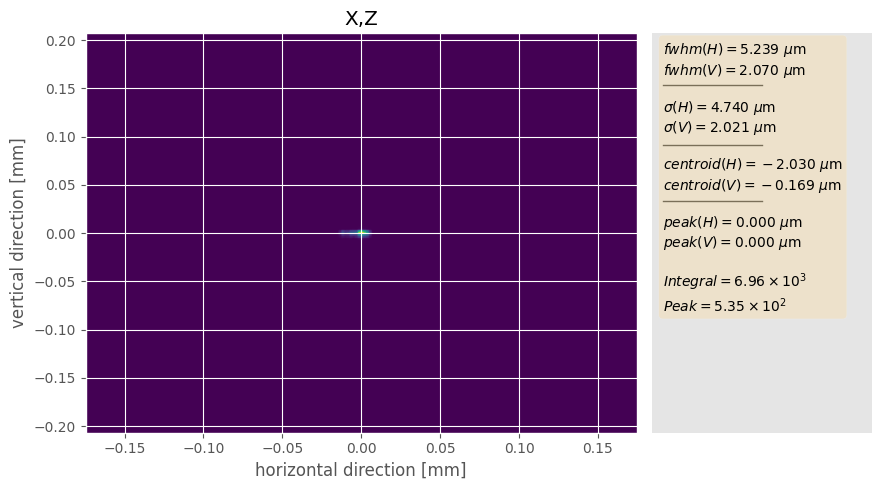

In [64]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

3
[0.51012292 0.44933506        nan]
2
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.


/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/optuna_botorch.py:340: RuntimeWarning: invalid value encountered in true_divide
  closeness = s_minus / (s_plus + s_minus)


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.002742187499999993, -0.9995578017577639, 0.002126152175007474]


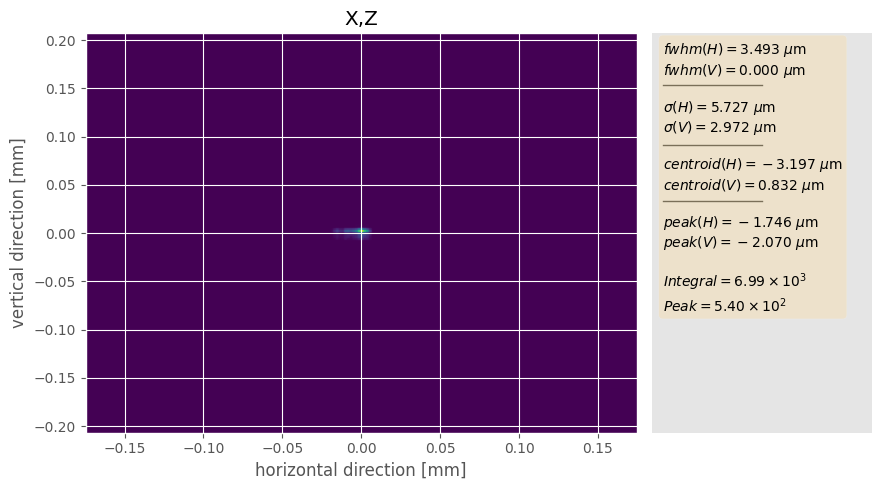

In [65]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.TOPSIS)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

### Different initial structure

In [66]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), list(initial_absolute_positions.values()), movement='absolute')

In [67]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-172.6, -161.2, 0.17248733853924986, 0.021399999999999995, 424.7, 0.17163733853924987, -0.0098]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-4.618757869440849, -0.24387517344727705, 0.0006361689799733881, 0.010677863583567614, 5.72939321409239, -0.0002463900499665619, -0.00976402756802906]


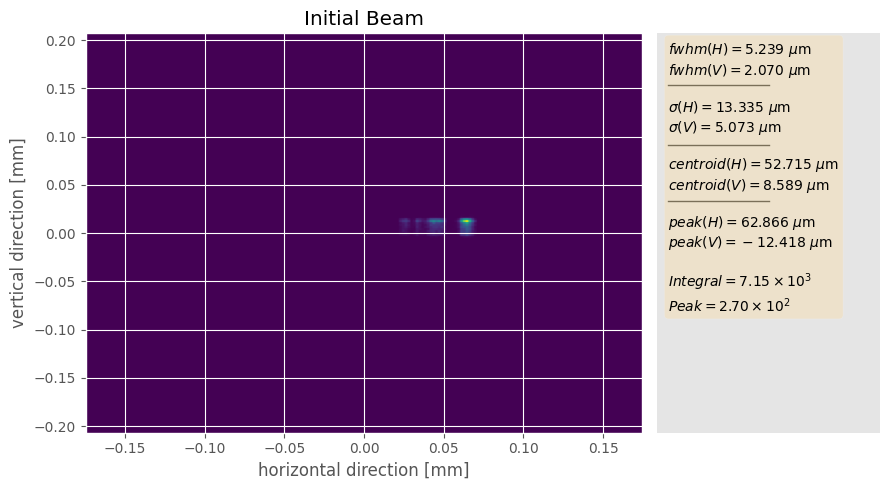

Perturbed beam system fwhm: 8.505e-03
Perturbed beam system log_weighted_sum_intensity: 3.087e+00
Perturbed beam system peak_distance: 6.544e-02


In [68]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert, ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam", calc_params=cp)

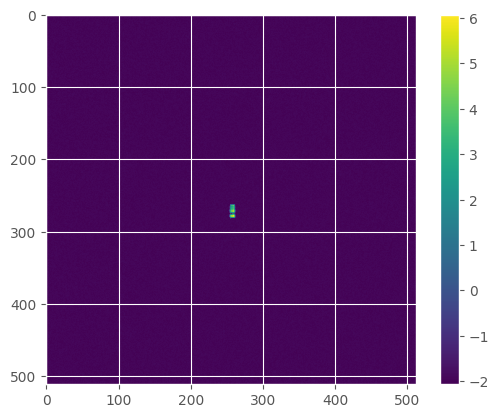

In [69]:
plt.imshow(np.log(hist_pert.data_2D))
plt.colorbar()

In [70]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

In [71]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

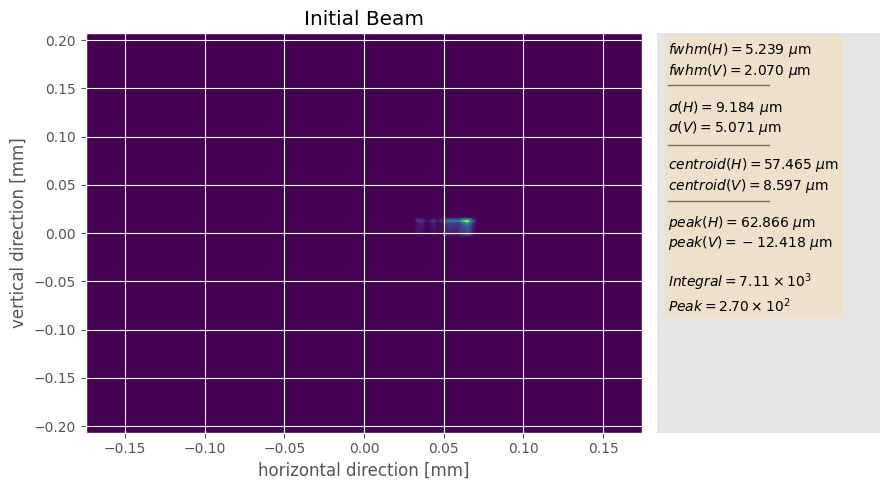

In [72]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [73]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam", calc_params=cp)

Perturbed beam system fwhm: 8.505e-03
Perturbed beam system log_weighted_sum_intensity: 3.211e+00
Perturbed beam system peak_distance: 6.544e-02


In [74]:
opt_params = OptimizationParameters()

In [75]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    )

In [76]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [77]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-01-22 14:34:42,149] A new study created in memory with name: no-name-c6bf7552-f3fc-45c1-8395-6f7af23dc9b4


In [78]:
opt_trial.trials(100)#, trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hb_1' with value 0.0 is out of range for distribution FloatDistribution(high=12.5, log=False, low=-12.5, step=1.0).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hb_2' with value 0.0 is out of range for distribution FloatDistribution(high=12.5, log=False, low=-12.5, step=1.0).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(
[I 2023-01-22 14:34:46,234] Trial 0 finished with values: [0.008504608700029895,

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:34:46,632] Trial 1 finished with values: [0.04935937499999987, 3.45064289425716, 0.05743359375000003] and parameters: {'hb_1': 2.5, 'hb_2': -8.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.008, 'vb_bender': -4.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.0144}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:34:47,035] Trial 2 finished with values: [0.057677575345656554, 3.983126239193261, 0.08773426169084962] and parameters: {'hb_1': -2.5, 'hb_2': -6.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.014700000000000001, 'vb_bender': -6.0, 'vb_pitch': -0.00084, 'vb_trans': 0.005000000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:34:47,446] Trial 3 finished with values: [0.010968749999999972, 3.786309231701856, 0.07570871296859003] and parameters: {'hb_1': 3.5, 'hb_2': -5.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.0115, 'vb_bender': -9.0, 'vb_pitch': 0.0008000000000000001, 'vb_trans': 0.008800000000000002}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:34:47,851] Trial 4 finished with values: [0.02821902685356972, 5.07776825245032, 0.16108325587371267] and parameters: {'hb_1': 8.5, 'hb_2': 8.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0023, 'vb_bender': 7.0, 'vb_pitch': -0.00015999999999999999, 'vb_trans': -0.014199999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:34:48,258] Trial 5 finished with values: [0.05250545509698389, 4.947454698806625, 0.12716656198826426] and parameters: {'hb_1': -1.5, 'hb_2': -10.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.0059000000000000025, 'vb_bender': 1.0, 'vb_pitch': -0.00046, 'vb_trans': 0.0149}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:34:48,655] Trial 6 finished with values: [0.01410951342678486, 3.0618090588307454, 0.0630255870629841] and parameters: {'hb_1': -9.5, 'hb_2': 3.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.002899999999999998, 'vb_bender': 5.0, 'vb_pitch': -0.00035999999999999997, 'vb_trans': -0.002999999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:34:49,053] Trial 7 finished with values: [0.004252304350014948, 4.852537228549869, 0.12967531857558964] and parameters: {'hb_1': -4.5, 'hb_2': 11.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': 0.009400000000000002, 'vb_bender': -10.0, 'vb_pitch': 0.0008800000000000001, 'vb_trans': 0.013500000000000002}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:34:49,450] Trial 8 finished with values: [0.00884527165023244, 5.386176871557081, 0.17767122817968017] and parameters: {'hb_1': 7.5, 'hb_2': -0.5, 'hb_pitch': 0.0009, 'hb_trans': -0.0024999999999999988, 'vb_bender': -4.0, 'vb_pitch': -0.00098, 'vb_trans': -0.0139}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:34:49,849] Trial 9 finished with values: [0.0303386414742635, 3.5609612752125557, 0.0710024483486928] and parameters: {'hb_1': -11.5, 'hb_2': -9.5, 'hb_pitch': -0.001, 'hb_trans': -0.008299999999999998, 'vb_bender': 1.0, 'vb_pitch': -0.00066, 'vb_trans': -0.0097}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:34:53,262] Trial 10 finished with values: [0.00884527165023244, 1.860986544889056, 0.03624888556510276] and parameters: {'hb_1': -4.5, 'hb_2': 0.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.0027999999999999987, 'vb_bender': 1.0, 'vb_pitch': -9.999999999999994e-05, 'vb_trans': -0.0033999999999999985}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:34:57,490] Trial 11 finished with values: [0.005484374999999986, 1.4965864339283381, 0.02728843763822608] and parameters: {'hb_1': -3.5, 'hb_2': 3.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.0030999999999999986, 'vb_bender': 0.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.0030999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:35:03,852] Trial 12 finished with values: [0.005484374999999986, 1.8580126985174865, 0.03095845077581369] and parameters: {'hb_1': -3.5, 'hb_2': 2.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.004399999999999999, 'vb_bender': -1.0, 'vb_pitch': 0.00026000000000000003, 'vb_trans': -0.0024999999999999988}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:35:09,100] Trial 13 finished with values: [0.010968749999999972, 1.833523283626425, 0.03476142552761489] and parameters: {'hb_1': -1.5, 'hb_2': 3.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.005999999999999998, 'vb_bender': -1.0, 'vb_pitch': -5.999999999999994e-05, 'vb_trans': -0.0024999999999999988}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:35:14,033] Trial 14 finished with values: [0.00705475671339243, 1.5793535859989398, 0.022113179125581174] and parameters: {'hb_1': -3.5, 'hb_2': 4.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -9.99999999999994e-05, 'vb_bender': 0.0, 'vb_pitch': 0.00023999999999999998, 'vb_trans': -0.0030999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:35:20,373] Trial 15 finished with values: [0.008504608700029895, 1.7101984328038775, 0.026502996599165034] and parameters: {'hb_1': -2.5, 'hb_2': 3.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.0026999999999999993, 'vb_bender': 2.0, 'vb_pitch': 0.00022000000000000014, 'vb_trans': -0.0030999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:35:27,434] Trial 16 finished with values: [0.004252304350014948, 1.4112891891501305, 0.023812941179168545] and parameters: {'hb_1': -4.5, 'hb_2': 3.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.001299999999999999, 'vb_bender': -2.0, 'vb_pitch': 0.0001200000000000001, 'vb_trans': -0.0052}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:35:31,319] Trial 17 finished with values: [0.016453124999999957, 1.328496885143233, 0.018342156570087403] and parameters: {'hb_1': -0.5, 'hb_2': 5.5, 'hb_pitch': -0.0005, 'hb_trans': 0.003100000000000002, 'vb_bender': -1.0, 'vb_pitch': 0.00026000000000000003, 'vb_trans': -0.0081}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:35:36,730] Trial 18 finished with values: [0.004252304350014948, 0.5044211468793236, 0.009734250381676215] and parameters: {'hb_1': -3.5, 'hb_2': 4.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.0001999999999999988, 'vb_bender': -1.0, 'vb_pitch': 0.00010000000000000005, 'vb_trans': -0.0063999999999999994}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:35:40,322] Trial 19 finished with values: [0.049466255168454105, 4.247327627144279, 0.11978108547725871] and parameters: {'hb_1': 8.5, 'hb_2': 8.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.014499999999999999, 'vb_bender': -8.0, 'vb_pitch': -0.00035999999999999997, 'vb_trans': -9.99999999999994e-05}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:35:43,731] Trial 20 finished with values: [0.006375019148255531, 2.5134337939758953, 0.04440735385926779] and parameters: {'hb_1': -8.5, 'hb_2': 9.5, 'hb_pitch': -0.0005, 'hb_trans': 0.0010000000000000009, 'vb_bender': 1.0, 'vb_pitch': -0.00052, 'vb_trans': -0.012899999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:35:48,466] Trial 21 finished with values: [0.0383906249999999, 5.0446435386780735, 0.16814168790792014] and parameters: {'hb_1': 12.5, 'hb_2': 6.5, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.006799999999999999, 'vb_bender': -7.0, 'vb_pitch': -0.00046, 'vb_trans': -0.004799999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:35:52,518] Trial 22 finished with values: [0.06381948620012257, 3.3127003236609953, 0.04762103607422064] and parameters: {'hb_1': -11.5, 'hb_2': -6.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.0149, 'vb_bender': 2.0, 'vb_pitch': -0.00046, 'vb_trans': -0.0030999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:35:56,024] Trial 23 finished with values: [0.04935937499999987, 2.9049274011974937, 0.04132561152121694] and parameters: {'hb_1': 4.5, 'hb_2': -10.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': 0.001800000000000003, 'vb_bender': -8.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': -0.007599999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:00,483] Trial 24 finished with values: [0.012756913050044843, 4.438149400712643, 0.11324789170751168] and parameters: {'hb_1': 3.5, 'hb_2': -2.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.0091, 'vb_bender': 4.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.005099999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:04,317] Trial 25 finished with values: [0.027894210422552752, 2.3014150717544823, 0.026502996599165034] and parameters: {'hb_1': -5.5, 'hb_2': 4.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': 0.008200000000000002, 'vb_bender': 3.0, 'vb_pitch': 0.00010000000000000005, 'vb_trans': -0.001199999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:07,455] Trial 26 finished with values: [0.008226562499999979, 3.3853561651536905, 0.07011301922237799] and parameters: {'hb_1': -1.5, 'hb_2': -0.5, 'hb_pitch': 0.0, 'hb_trans': -0.0014999999999999996, 'vb_bender': -3.0, 'vb_pitch': -3.999999999999989e-05, 'vb_trans': 0.014400000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:10,365] Trial 27 finished with values: [0.03642739796177607, 3.3941127343950215, 0.044912477447733426] and parameters: {'hb_1': -7.5, 'hb_2': -1.5, 'hb_pitch': -0.0007, 'hb_trans': -0.0013999999999999985, 'vb_bender': 10.0, 'vb_pitch': 0.0008800000000000001, 'vb_trans': 0.004400000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:13,350] Trial 28 finished with values: [0.03364831687492875, 3.3110008070192323, 0.054962135320325116] and parameters: {'hb_1': 2.5, 'hb_2': 8.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.008, 'vb_bender': 8.0, 'vb_pitch': 0.0008000000000000001, 'vb_trans': 0.0016000000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:16,339] Trial 29 finished with values: [0.004252304350014948, 3.4640514803928215, 0.06113997125117677] and parameters: {'hb_1': -4.5, 'hb_2': 9.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.012400000000000001, 'vb_bender': 1.0, 'vb_pitch': -0.00019999999999999998, 'vb_trans': 0.0038000000000000013}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:19,302] Trial 30 finished with values: [0.03564843749999991, 3.404697735362661, 0.07127475423619964] and parameters: {'hb_1': -12.5, 'hb_2': -7.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': -0.003299999999999999, 'vb_bender': -2.0, 'vb_pitch': 0.0006200000000000001, 'vb_trans': -0.0093}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:22,201] Trial 31 finished with values: [0.03306635433582744, 4.154285514529992, 0.09312091940317796] and parameters: {'hb_1': -5.5, 'hb_2': 1.5, 'hb_pitch': -0.0005, 'hb_trans': 0.010900000000000003, 'vb_bender': -5.0, 'vb_pitch': -0.00096, 'vb_trans': 0.005000000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:25,803] Trial 32 finished with values: [0.03642739796177607, 5.0631621357201855, 0.14601375572514366] and parameters: {'hb_1': 11.5, 'hb_2': -3.5, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.005099999999999999, 'vb_bender': 9.0, 'vb_pitch': 0.0, 'vb_trans': 0.003100000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:29,198] Trial 33 finished with values: [0.00884527165023244, 4.774552138873901, 0.13920541161069885] and parameters: {'hb_1': -11.5, 'hb_2': -5.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': -0.0096, 'vb_bender': 1.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': -0.0063999999999999994}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:32,508] Trial 34 finished with values: [0.00884527165023244, 0.8657984337256774, 0.010764786597660133] and parameters: {'hb_1': -4.5, 'hb_2': 5.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0023999999999999994, 'vb_bender': -4.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': -0.0034999999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:35,848] Trial 35 finished with values: [0.0111866379730741, 4.9176588194179045, 0.14008249658761696] and parameters: {'hb_1': 12.5, 'hb_2': -7.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': -0.0002999999999999982, 'vb_bender': 3.0, 'vb_pitch': 0.0, 'vb_trans': 0.006500000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:39,276] Trial 36 finished with values: [0.0383906249999999, 4.476991246361547, 0.10041908407717831] and parameters: {'hb_1': -8.5, 'hb_2': 6.5, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.013800000000000003, 'vb_bender': -7.0, 'vb_pitch': -0.00011999999999999999, 'vb_trans': -0.011699999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:42,738] Trial 37 finished with values: [0.03623618490116473, 4.165384984793961, 0.10834639946025422] and parameters: {'hb_1': 5.5, 'hb_2': 6.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.010499999999999999, 'vb_bender': 0.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': -0.0052}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:45,891] Trial 38 finished with values: [0.005484374999999986, 5.123420691141022, 0.15752020429567934] and parameters: {'hb_1': -11.5, 'hb_2': -1.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': -0.013, 'vb_bender': -9.0, 'vb_pitch': 0.0008000000000000001, 'vb_trans': 0.013400000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:50,504] Trial 39 finished with values: [0.008504608700029895, 5.129049947655818, 0.16504297651608824] and parameters: {'hb_1': -9.5, 'hb_2': -2.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': -0.0107, 'vb_bender': -1.0, 'vb_pitch': -0.0007, 'vb_trans': -0.0136}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:36:53,698] Trial 40 finished with values: [0.002742187499999993, 2.9980451501901495, 0.04389641811208847] and parameters: {'hb_1': -11.5, 'hb_2': 1.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.005400000000000002, 'vb_bender': -7.0, 'vb_pitch': -0.0006000000000000001, 'vb_trans': -0.0143}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:37:02,025] Trial 41 finished with values: [0.014090858991875019, 0.6192837204491223, 0.005064140901603024] and parameters: {'hb_1': -7.5, 'hb_2': 4.5, 'hb_pitch': -0.0005, 'hb_trans': -0.0001999999999999988, 'vb_bender': -2.0, 'vb_pitch': -5.999999999999994e-05, 'vb_trans': -0.010199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:37:10,294] Trial 42 finished with values: [0.002742187499999993, -0.19085852610307905, 0.005064140901603024] and parameters: {'hb_1': -2.5, 'hb_2': 3.5, 'hb_pitch': -0.0005, 'hb_trans': -0.0007999999999999986, 'vb_bender': -3.0, 'vb_pitch': 0.0, 'vb_trans': -0.005899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:37:13,954] Trial 43 finished with values: [0.022176934103928733, 0.9718455600167841, 0.009106849490444066] and parameters: {'hb_1': 0.5, 'hb_2': -4.5, 'hb_pitch': -0.0007, 'hb_trans': -0.001599999999999999, 'vb_bender': -6.0, 'vb_pitch': 0.00014000000000000015, 'vb_trans': 0.011300000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:37:18,265] Trial 44 finished with values: [0.04201705804198919, 5.313173365553453, 0.18282627389516964] and parameters: {'hb_1': 12.5, 'hb_2': 4.5, 'hb_pitch': 0.0009, 'hb_trans': -0.003999999999999998, 'vb_bender': 10.0, 'vb_pitch': 0.0006000000000000001, 'vb_trans': -0.0103}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:37:21,546] Trial 45 finished with values: [0.043874999999999886, 3.990830758846186, 0.09171685616456725] and parameters: {'hb_1': 1.5, 'hb_2': -10.5, 'hb_pitch': -0.0008, 'hb_trans': -0.0002999999999999982, 'vb_bender': -10.0, 'vb_pitch': -0.00076, 'vb_trans': 0.0142}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:37:24,822] Trial 46 finished with values: [0.006375019148255531, 3.069823851383092, 0.05279650636732249] and parameters: {'hb_1': -1.5, 'hb_2': -12.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': -0.008799999999999999, 'vb_bender': -8.0, 'vb_pitch': -0.00019999999999999998, 'vb_trans': -0.0126}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:37:28,499] Trial 47 finished with values: [0.016453124999999957, 3.381716414482587, 0.06271138970751523] and parameters: {'hb_1': 12.5, 'hb_2': 3.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': 0.012100000000000003, 'vb_bender': -6.0, 'vb_pitch': -0.0005, 'vb_trans': 0.011600000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:37:32,673] Trial 48 finished with values: [0.016771041180130213, 3.7094907172697673, 0.07950898979749502] and parameters: {'hb_1': -0.5, 'hb_2': 8.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.0019999999999999983, 'vb_bender': -9.0, 'vb_pitch': 0.00044000000000000007, 'vb_trans': 0.011500000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:37:37,912] Trial 49 finished with values: [0.05242287920517273, 3.086212376376703, 0.06980560263197698] and parameters: {'hb_1': -11.5, 'hb_2': -5.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': 0.0051, 'vb_bender': 10.0, 'vb_pitch': -0.00011999999999999999, 'vb_trans': 0.007300000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:37:44,347] Trial 50 finished with values: [0.005484374999999986, -0.2692729311567062, 0.008239873971808606] and parameters: {'hb_1': 2.5, 'hb_2': -1.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0017999999999999995, 'vb_bender': -5.0, 'vb_pitch': -9.999999999999994e-05, 'vb_trans': -0.010499999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:37:50,426] Trial 51 finished with values: [0.05484374999999986, 4.589456724943669, 0.10057191627093132] and parameters: {'hb_1': -9.5, 'hb_2': -10.5, 'hb_pitch': 0.0005, 'hb_trans': 0.004900000000000002, 'vb_bender': -8.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': 0.013800000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:37:56,098] Trial 52 finished with values: [0.0223732759461482, 4.184932534041226, 0.09688307937894154] and parameters: {'hb_1': 4.5, 'hb_2': 9.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.0023999999999999994, 'vb_bender': 7.0, 'vb_pitch': 0.00084, 'vb_trans': 0.0025000000000000022}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:38:00,584] Trial 53 finished with values: [0.008226562499999979, 3.7777474617311864, 0.07866763047527695] and parameters: {'hb_1': 12.5, 'hb_2': -10.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.006299999999999998, 'vb_bender': -9.0, 'vb_pitch': 0.0009600000000000003, 'vb_trans': 0.006700000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:38:04,859] Trial 54 finished with values: [0.013710937499999964, 0.5739555620113641, 0.002126152175007474] and parameters: {'hb_1': -1.5, 'hb_2': 0.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.0007000000000000027, 'vb_bender': -10.0, 'vb_pitch': 7.999999999999999e-05, 'vb_trans': -0.0073999999999999995}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:38:10,022] Trial 55 finished with values: [0.005484374999999986, 1.2367488715830581, 0.02152172640941246] and parameters: {'hb_1': 7.5, 'hb_2': -3.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0030999999999999986, 'vb_bender': -6.0, 'vb_pitch': -9.999999999999994e-05, 'vb_trans': 0.0046}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:38:16,364] Trial 56 finished with values: [0.0202659818901689, 0.0726450661788017, 0.0070454294959375096] and parameters: {'hb_1': 0.5, 'hb_2': -4.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.002599999999999998, 'vb_bender': 0.0, 'vb_pitch': -1.9999999999999836e-05, 'vb_trans': -0.0144}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:38:22,151] Trial 57 finished with values: [0.00884527165023244, 0.4868742431240925, 0.009734250381676215] and parameters: {'hb_1': -2.5, 'hb_2': -5.5, 'hb_pitch': -0.0007, 'hb_trans': -0.006699999999999999, 'vb_bender': -3.0, 'vb_pitch': 0.0001200000000000001, 'vb_trans': -0.0001999999999999988}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:38:27,958] Trial 58 finished with values: [0.008226562499999979, -0.3104302485297009, 0.0070454294959375096] and parameters: {'hb_1': 0.5, 'hb_2': 3.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0033999999999999985, 'vb_bender': -2.0, 'vb_pitch': 0.00014000000000000015, 'vb_trans': 0.003100000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:38:33,784] Trial 59 finished with values: [0.013710937499999964, 1.6982485392279807, 0.017493016620730786] and parameters: {'hb_1': -5.5, 'hb_2': -0.5, 'hb_pitch': -0.0007, 'hb_trans': -0.002199999999999999, 'vb_bender': -5.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': -0.012299999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:38:40,109] Trial 60 finished with values: [0.011440103870267053, 0.5183401974557249, 0.015192422704809179] and parameters: {'hb_1': 0.5, 'hb_2': -3.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0037999999999999996, 'vb_bender': -8.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.008299999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:38:46,146] Trial 61 finished with values: [0.008226562499999979, 0.528464533300362, 0.006378456525022422] and parameters: {'hb_1': -4.5, 'hb_2': 4.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.003999999999999998, 'vb_bender': 0.0, 'vb_pitch': 7.999999999999999e-05, 'vb_trans': -0.0009999999999999992}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:38:52,826] Trial 62 finished with values: [0.013710937499999964, 0.09891202042825874, 0.012446379745709724] and parameters: {'hb_1': 1.5, 'hb_2': 1.5, 'hb_pitch': -0.0007, 'hb_trans': -0.011099999999999999, 'vb_bender': -1.0, 'vb_pitch': 0.00026000000000000003, 'vb_trans': 0.008200000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:38:59,410] Trial 63 finished with values: [0.016453124999999957, 1.349507743809684, 0.02152172640941246] and parameters: {'hb_1': -1.5, 'hb_2': 3.5, 'hb_pitch': -0.0005, 'hb_trans': 0.0029, 'vb_bender': -3.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': 0.00010000000000000113}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:39:07,160] Trial 64 finished with values: [0.005484374999999986, -0.27260072944643254, 0.002126152175007474] and parameters: {'hb_1': 0.5, 'hb_2': 0.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.001899999999999999, 'vb_bender': -3.0, 'vb_pitch': 4.0000000000000105e-05, 'vb_trans': -0.008}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:39:12,094] Trial 65 finished with values: [0.013710937499999964, -0.8888726565779076, 0.0070454294959375096] and parameters: {'hb_1': 3.5, 'hb_2': -2.5, 'hb_pitch': -0.0007, 'hb_trans': -0.0121, 'vb_bender': -2.0, 'vb_pitch': 0.0002000000000000001, 'vb_trans': 0.007800000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:39:16,760] Trial 66 finished with values: [0.005484374999999986, 0.45214696294039525, 0.010764786597660133] and parameters: {'hb_1': 4.5, 'hb_2': -0.5, 'hb_pitch': -0.0007, 'hb_trans': -0.0014999999999999996, 'vb_bender': -7.0, 'vb_pitch': 7.999999999999999e-05, 'vb_trans': 0.001400000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:39:21,667] Trial 67 finished with values: [0.006375019148255531, -0.2934321120597299, 0.009106849490444066] and parameters: {'hb_1': -1.5, 'hb_2': -2.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.009, 'vb_bender': -6.0, 'vb_pitch': 4.0000000000000105e-05, 'vb_trans': -0.0132}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:39:26,871] Trial 68 finished with values: [0.008226562499999979, -0.3472385751326442, 0.005064140901603024] and parameters: {'hb_1': 10.5, 'hb_2': -5.5, 'hb_pitch': -0.0007, 'hb_trans': -0.0036999999999999984, 'vb_bender': -3.0, 'vb_pitch': 7.999999999999999e-05, 'vb_trans': -0.0101}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:39:33,441] Trial 69 finished with values: [0.011440103870267053, 1.2549382885753386, 0.023365169967336882] and parameters: {'hb_1': 9.5, 'hb_2': -11.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0113, 'vb_bender': 2.0, 'vb_pitch': 7.999999999999999e-05, 'vb_trans': -0.009399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:39:39,282] Trial 70 finished with values: [0.011440103870267053, 0.08500412907525698, 0.002126152175007474] and parameters: {'hb_1': -3.5, 'hb_2': -1.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0132, 'vb_bender': 1.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': -0.0013999999999999985}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:39:44,529] Trial 71 finished with values: [0.031700680852371294, 0.9558338959384844, 0.018342156570087403] and parameters: {'hb_1': 11.5, 'hb_2': -4.5, 'hb_pitch': -0.0007, 'hb_trans': -0.014799999999999999, 'vb_bender': 3.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': 0.004700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:39:50,164] Trial 72 finished with values: [0.01919531249999995, -0.18175693268945795, 0.0070454294959375096] and parameters: {'hb_1': 1.5, 'hb_2': -5.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.004199999999999999, 'vb_bender': -1.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': 0.0020000000000000018}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:39:56,160] Trial 73 finished with values: [0.005484374999999986, -0.4205333507921393, 0.006378456525022422] and parameters: {'hb_1': 2.5, 'hb_2': -2.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0086, 'vb_bender': -3.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': -0.0024999999999999988}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:40:02,560] Trial 74 finished with values: [0.00884527165023244, 0.19897147187463504, 0.006378456525022422] and parameters: {'hb_1': 2.5, 'hb_2': -11.5, 'hb_pitch': -0.0008, 'hb_trans': -0.0146, 'vb_bender': -3.0, 'vb_pitch': 0.0002800000000000001, 'vb_trans': 0.006500000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:40:08,663] Trial 75 finished with values: [0.022176934103928733, 0.9923595570804012, 0.021008529020994673] and parameters: {'hb_1': 9.5, 'hb_2': -5.5, 'hb_pitch': -0.0008, 'hb_trans': -0.013, 'vb_bender': -7.0, 'vb_pitch': 0.00026000000000000003, 'vb_trans': -0.004799999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:40:14,033] Trial 76 finished with values: [0.01919531249999995, -0.10118070912105384, 0.002126152175007474] and parameters: {'hb_1': 4.5, 'hb_2': 7.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0040999999999999995, 'vb_bender': -3.0, 'vb_pitch': -3.999999999999989e-05, 'vb_trans': -0.0149}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:40:19,533] Trial 77 finished with values: [0.015384288432241619, 0.5354265558566703, 0.00442263582511622] and parameters: {'hb_1': 1.5, 'hb_2': -2.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.011399999999999999, 'vb_bender': 6.0, 'vb_pitch': 7.999999999999999e-05, 'vb_trans': -0.0118}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:40:25,122] Trial 78 finished with values: [0.005484374999999986, -0.7111555142541445, 0.009106849490444066] and parameters: {'hb_1': 9.5, 'hb_2': -2.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0017999999999999995, 'vb_bender': -1.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': 0.009400000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:40:32,330] Trial 79 finished with values: [0.00884527165023244, -0.0011827769244892583, 0.006378456525022422] and parameters: {'hb_1': -1.5, 'hb_2': -9.5, 'hb_pitch': -0.0007, 'hb_trans': -0.0144, 'vb_bender': 2.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': 0.002400000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:40:39,296] Trial 80 finished with values: [0.005484374999999986, 1.9162340243096287, 0.028838787672828388] and parameters: {'hb_1': 7.5, 'hb_2': -1.5, 'hb_pitch': -0.0009, 'hb_trans': -0.0033999999999999985, 'vb_bender': 0.0, 'vb_pitch': 0.0002000000000000001, 'vb_trans': 0.0046}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:40:47,727] Trial 81 finished with values: [0.00884527165023244, -0.44902057095307957, 0.008239873971808606] and parameters: {'hb_1': 8.5, 'hb_2': 1.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.006299999999999998, 'vb_bender': -10.0, 'vb_pitch': 0.0, 'vb_trans': -0.004599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:40:56,489] Trial 82 finished with values: [0.005484374999999986, -0.7984412330972944, 0.002126152175007474] and parameters: {'hb_1': 12.5, 'hb_2': -2.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.0045000000000000005, 'vb_bender': -3.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': 0.0013000000000000025}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:41:03,337] Trial 83 finished with values: [0.002742187499999993, -0.15918586837168577, 0.005064140901603024] and parameters: {'hb_1': 7.5, 'hb_2': -1.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.005000000000000001, 'vb_bender': -8.0, 'vb_pitch': 0.0002000000000000001, 'vb_trans': 0.0103}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:41:09,905] Trial 84 finished with values: [0.022176934103928733, 0.8260412474998238, 0.023365169967336882] and parameters: {'hb_1': 8.5, 'hb_2': -1.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.009900000000000003, 'vb_bender': -10.0, 'vb_pitch': 4.0000000000000105e-05, 'vb_trans': -0.007899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:41:16,448] Trial 85 finished with values: [0.01919531249999995, 0.05042511725440367, 0.008239873971808606] and parameters: {'hb_1': 10.5, 'hb_2': 2.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.004399999999999999, 'vb_bender': -9.0, 'vb_pitch': 0.0001200000000000001, 'vb_trans': -0.0087}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:41:23,456] Trial 86 finished with values: [0.005484374999999986, 0.4681964913202851, 0.01257500021841604] and parameters: {'hb_1': 8.5, 'hb_2': -1.5, 'hb_pitch': -0.0007, 'hb_trans': -0.007699999999999999, 'vb_bender': 1.0, 'vb_pitch': 0.0003200000000000002, 'vb_trans': 0.005000000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:41:30,912] Trial 87 finished with values: [0.024892759491419447, 0.9681029368356542, 0.0070454294959375096] and parameters: {'hb_1': 9.5, 'hb_2': -3.5, 'hb_pitch': -0.0007, 'hb_trans': 0.006500000000000002, 'vb_bender': 0.0, 'vb_pitch': 6.000000000000016e-05, 'vb_trans': -0.010199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:41:38,469] Trial 88 finished with values: [0.00884527165023244, 1.3997571947989007, 0.01913536957506735] and parameters: {'hb_1': 1.5, 'hb_2': -11.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0126, 'vb_bender': -1.0, 'vb_pitch': 0.00034, 'vb_trans': 0.002400000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:41:50,377] Trial 89 finished with values: [0.018213698980888034, 0.14560335884586456, 0.008239873971808606] and parameters: {'hb_1': 2.5, 'hb_2': -3.5, 'hb_pitch': -0.0007, 'hb_trans': -0.011899999999999999, 'vb_bender': 7.0, 'vb_pitch': 0.00023999999999999998, 'vb_trans': 0.0063}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:42:02,883] Trial 90 finished with values: [0.019125057444766596, -0.2978392892600642, 0.010764786597660133] and parameters: {'hb_1': 9.5, 'hb_2': -1.5, 'hb_pitch': -0.0007, 'hb_trans': -0.009399999999999999, 'vb_bender': 2.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.006699999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:42:12,917] Trial 91 finished with values: [0.011440103870267053, 0.7991815713275433, 0.015850340426185647] and parameters: {'hb_1': -6.5, 'hb_2': -3.5, 'hb_pitch': -0.0005, 'hb_trans': -0.0143, 'vb_bender': -8.0, 'vb_pitch': 0.0002000000000000001, 'vb_trans': 0.009800000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:42:22,259] Trial 92 finished with values: [0.00884527165023244, -1.1721596364325848, 0.002126152175007474] and parameters: {'hb_1': 7.5, 'hb_2': 2.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.003599999999999999, 'vb_bender': -8.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.011399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:42:32,140] Trial 93 finished with values: [0.01769054330046488, 1.8634812545032216, 0.03476142552761489] and parameters: {'hb_1': 2.5, 'hb_2': 12.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.0037999999999999996, 'vb_bender': 1.0, 'vb_pitch': 0.00030000000000000014, 'vb_trans': -0.002599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:42:40,672] Trial 94 finished with values: [0.008504608700029895, -0.14945560735596147, 0.012095854977702155] and parameters: {'hb_1': 1.5, 'hb_2': 2.5, 'hb_pitch': -0.0005, 'hb_trans': -0.002599999999999998, 'vb_bender': 1.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.001899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:42:49,095] Trial 95 finished with values: [0.004252304350014948, 0.4421504314807928, 0.008412079218732188] and parameters: {'hb_1': -3.5, 'hb_2': -3.5, 'hb_pitch': -0.0007, 'hb_trans': -0.009399999999999999, 'vb_bender': 2.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': 0.0057}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:42:57,221] Trial 96 finished with values: [0.005484374999999986, 5.079989994926736, 0.1522694643103224] and parameters: {'hb_1': 11.5, 'hb_2': 3.5, 'hb_pitch': 0.0009, 'hb_trans': 0.009300000000000003, 'vb_bender': -8.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.0141}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:43:04,547] Trial 97 finished with values: [0.049466255168454105, 1.0253910283194958, 0.01789813954152358] and parameters: {'hb_1': 6.5, 'hb_2': -5.5, 'hb_pitch': -0.0005, 'hb_trans': 0.012100000000000003, 'vb_bender': -3.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': -0.0005999999999999981}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 14:43:12,098] Trial 98 finished with values: [0.005484374999999986, -0.4104859616032012, 0.0070454294959375096] and parameters: {'hb_1': 3.5, 'hb_2': 2.5, 'hb_pitch': -0.0005, 'hb_trans': -0.001899999999999999, 'vb_bender': -10.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': 0.0009000000000000015}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(
[I 2023-01-22 14:43:19,609] Trial 99 finished with values: [0.010968749999999972, -0.044546612464410766, 0.0070454294959375096] and parameters: {'hb_1': 3.5, 'hb_2': 2.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.0023, 'vb_bender': -5.0, 'vb_pitch': -3.999999999999989e-05, 'vb_trans': -0.0141}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_38118/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3DSubplot:title={'center':'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

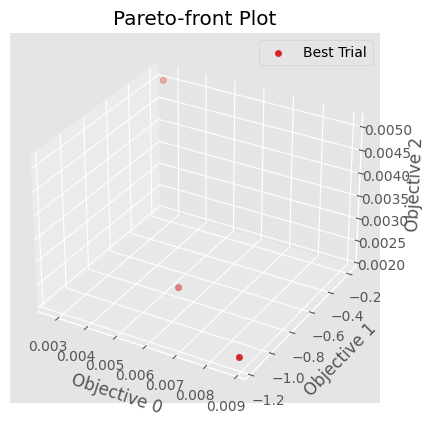

In [85]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [86]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

nan 0.8262494726156684
nan 0.4500299093981397
nan 0.30969738477119346


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_38118/2890865355.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs['ws'])


[0.002742187499999993, -0.19085852610307905, 0.005064140901603024]


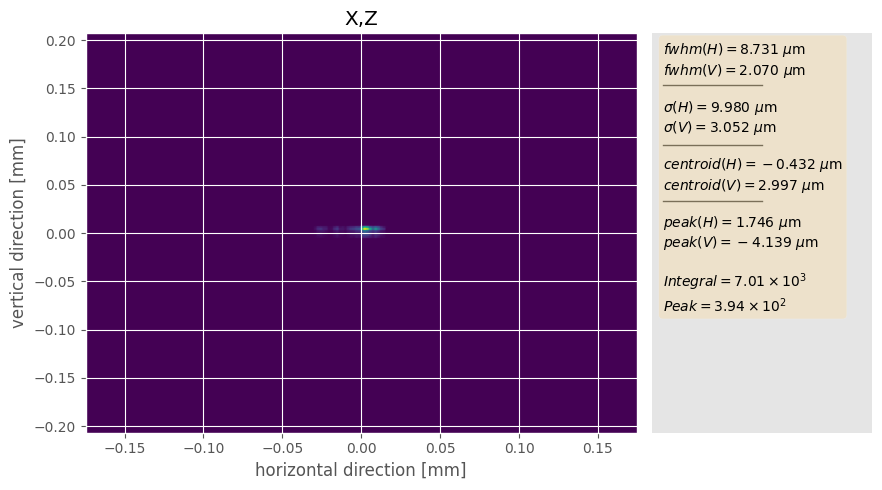

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.005484374999999986, -0.7984412330972944, 0.002126152175007474]


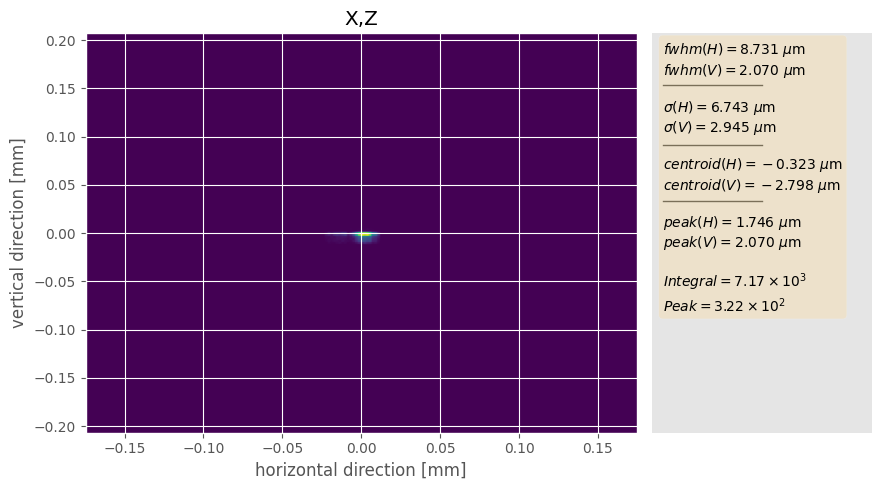

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.00884527165023244, -1.1721596364325848, 0.002126152175007474]


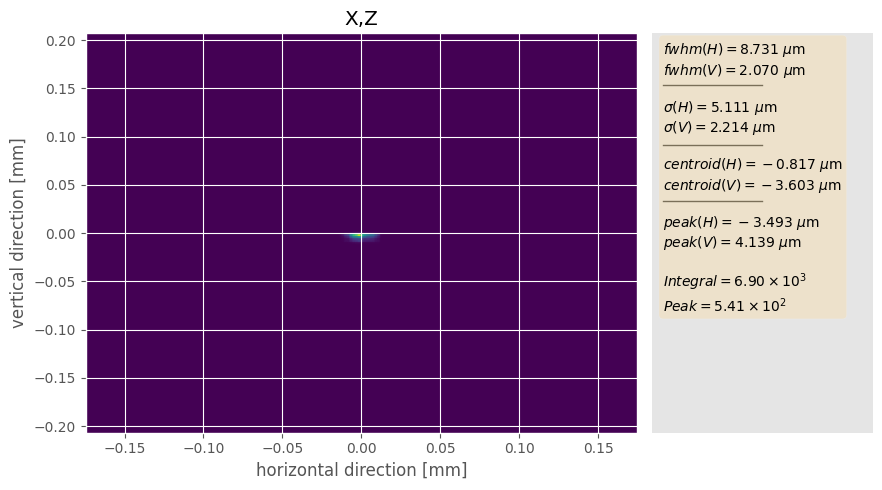

In [87]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    
    opt_common.plot_distribution(
        photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    #plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    #print(vals)
    #plt.figure(figsize=[5, 5])
    #plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    #plt.axis("off")
    #plt.show()

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.005484374999999986, -0.7984412330972944, 0.002126152175007474]


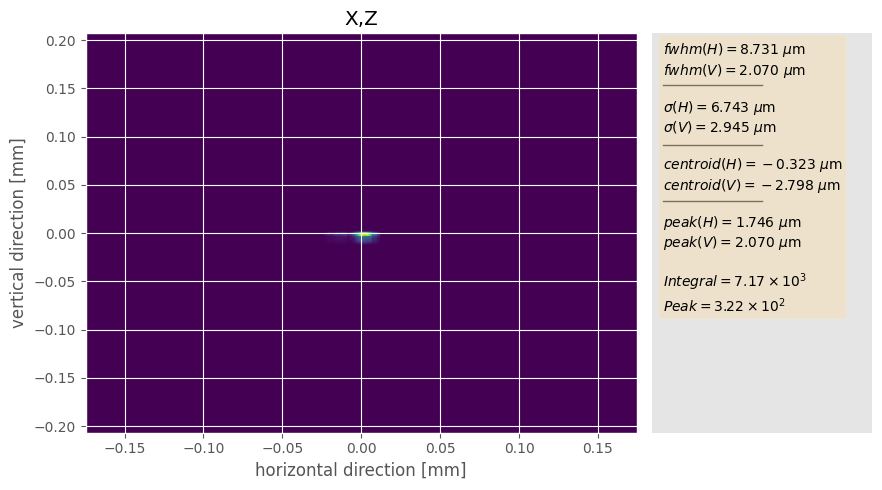

In [88]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

3
[0.489879   0.47638304 0.41421356]
0
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.002742187499999993, -0.19085852610307905, 0.005064140901603024]


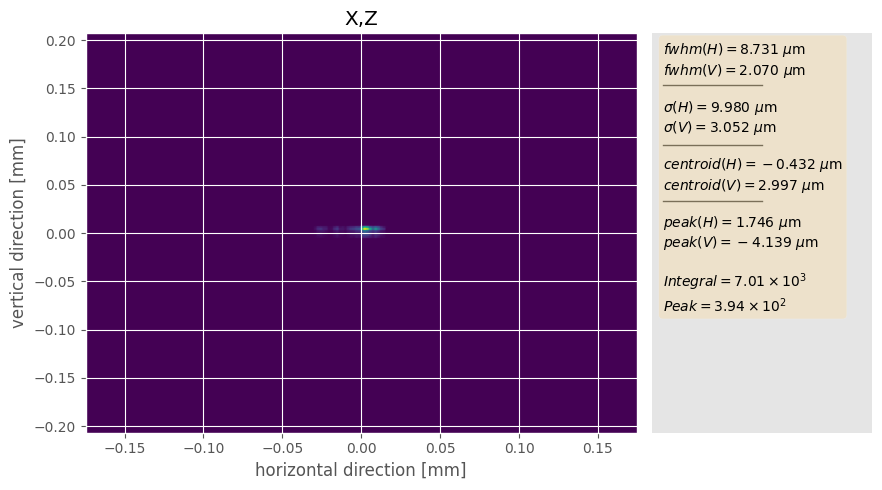

In [89]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.TOPSIS)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)